In [1]:
!pip install openpyxl

In [2]:
import yahoo_fin.stock_info as si
import datetime
import tkinter as tk
from tkinter import filedialog
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import webbrowser
import ta
from ta.utils import dropna
import warnings

In [3]:
## get data from "Yahoo! Finance" >>>
#
#tcr='SNOW'
tcr='NVDA'

In [4]:
# 3 years period >>
start = str( datetime.date.today().year-3 )

'''
start='2019-12-01'
end = '2020-09-01'
df=si.get_data(tcr, start_date=start, end_date=end, interval='1d')

help(si.get_data)

# Only 7 days worth of 1m (minute) granularity data
#  are allowed to be fetched per request !!! >>>

now = datetime.datetime.now()
now
d = datetime.timedelta(days = 6)
ago = now - d
ago
year = '{:02d}'.format(ago.year)
month = '{:02d}'.format(ago.month)
day = '{:02d}'.format(ago.day)
hour = '{:02d}'.format(ago.hour)
minute = '{:02d}'.format(ago.minute)
day_month_year = '{}-{}-{}'.format(year, month, day)
print('day_month_year: ' + day_month_year)
start = '{}-{}-{}'.format(year, month, day)
df=si.get_data(tcr, start_date=start, interval='1m')
'''
df=si.get_data(tcr, start_date=start, interval='1d')
print('\n', df.columns, '\n\n', df.index)
print('\n', df)


 Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object') 

 DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2024-05-23', '2024-05-24', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31', '2024-06-03', '2024-06-04',
               '2024-06-05', '2024-06-06'],
              dtype='datetime64[ns]', length=862, freq=None)

                    open         high          low        close     adjclose  \
2021-01-04   131.042496   136.524994   129.625000   131.134995   130.833954   
2021-01-05   130.997498   134.434998   130.869995   134.047501   133.739746   
2021-01-06   132.225006   132.449997   125.860001   126.144997   125.855423   
2021-01-07   129.675003   133.777496   128.865005   133.440002   133.133667   
2021-01-08   133.625000   134.210007   130.419998   132.767

In [5]:
print('\n', df.isnull().sum())


 open        0
high        0
low         0
close       0
adjclose    0
volume      0
ticker      0
dtype: int64


C:\Users\mixas\anaconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


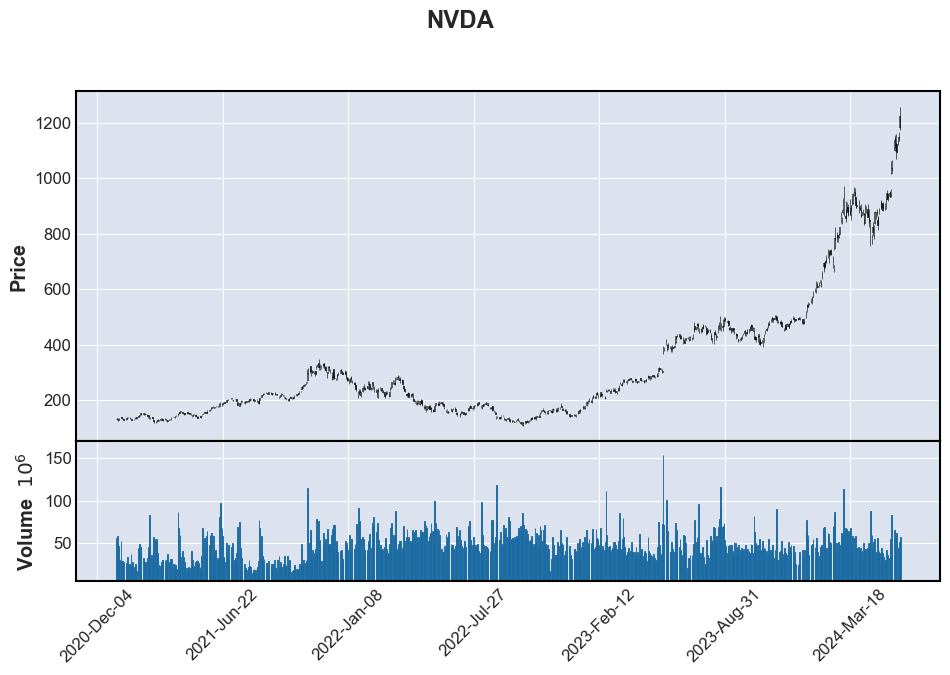

In [6]:
mpf.plot(df, type='candle', volume=True,
         main_panel=0, volume_panel=1, figsize=(12,7),
         show_nontrading=True, title=tcr)

In [7]:
price = 'adjclose'
pt = "Adjusted Closing Price"

In [8]:
##
### Simple Moving Averages (SMA) >>>
##
ind='SMA'

# Initialize the short and long windows
short = 10
long = 20

df['fast']=ta.trend.sma_indicator(df[price], window=short)
df['slow']=ta.trend.sma_indicator(df[price], window=long)

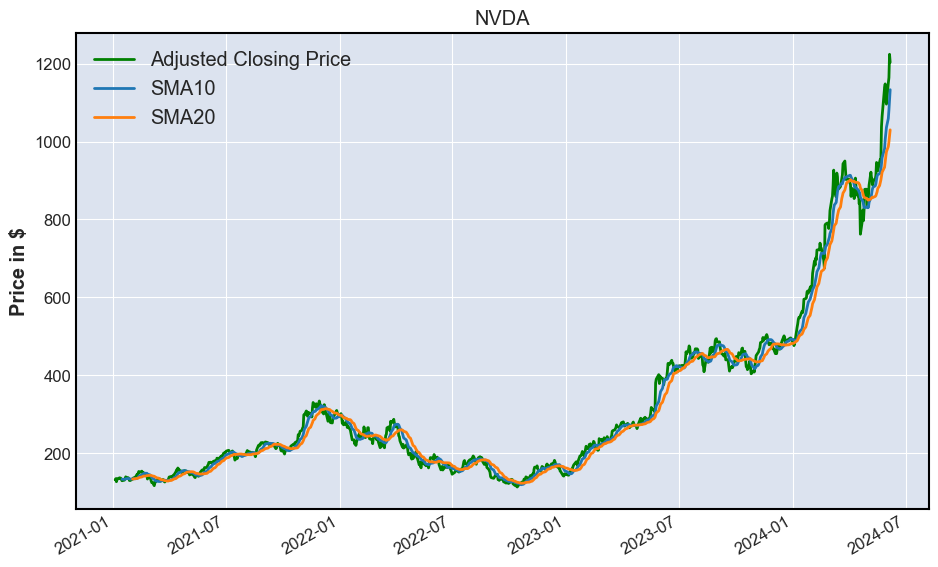

In [9]:
# plot >>>
fig = plt.figure(figsize=(11,7))
ax1 = fig.add_subplot(111,  ylabel='Price in $')
df[price].plot(ax=ax1, color='g', lw=2.)
df[['fast','slow']].plot(ax=ax1, lw=2., title=tcr)
plt.legend([pt, ind+str(short), ind+str(long)],
           fontsize='large')

In [10]:
# initialize `signal` column
df['signal'] = 0.0

# create signals
df['signal'][short:] = np.where(df['fast'][short:] 
                                > df['slow'][short:],
                                1.0, 0.0)   

# generate trading orders
df['positions'] = df['signal'].diff()

# print `signals`
print(df['signal'],'\n\n',
      pd.crosstab(df.signal, df.positions))

2021-01-04    0.0
2021-01-05    0.0
2021-01-06    0.0
2021-01-07    0.0
2021-01-08    0.0
             ... 
2024-05-31    1.0
2024-06-03    1.0
2024-06-04    1.0
2024-06-05    1.0
2024-06-06    1.0
Name: signal, Length: 862, dtype: float64 

 positions  -1.0   0.0   1.0
signal                     
0.0          20   313     0
1.0           0   507    21


C:\Users\mixas\AppData\Local\Temp\ipykernel_10040\17856893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short:] = np.where(df['fast'][short:]


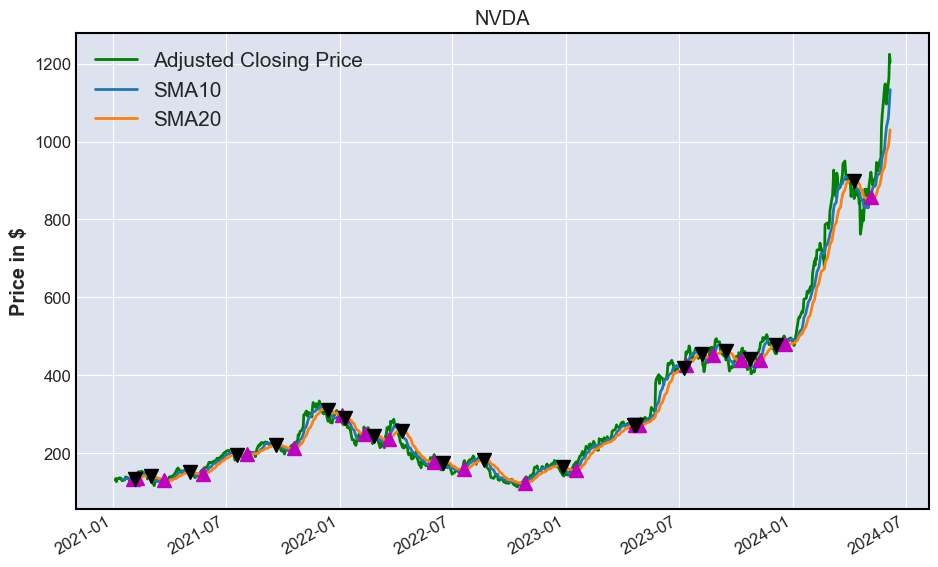

In [11]:
# Initialize the plot figure
fig = plt.figure(figsize=(11,7))

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')

# Plot the closing price
df[price].plot(ax=ax1, color='g', lw=2., label="Close")

# Plot the short and long moving averages
df[['fast', 'slow']].plot(ax=ax1, lw=2., title=tcr)

# Plot the buy signals
ax1.plot(df.loc[df.positions == 1.0].index, 
         df.fast[df.positions == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(df.loc[df.positions == -1.0].index, 
         df.fast[df.positions == -1.0],
         'v', markersize=10, color='k')

plt.legend([pt, ind+str(short), ind+str(long)],
           loc='best', fontsize=15)

In [12]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=df.index)

# Would you buy *spd* shares a day?
spd = 100
positions[tcr] = spd*df.signal
'''
print('\n',pd.crosstab(df.signal, df.positions))
print('\n',df.groupby(by=['signal']).sum())
'''
  
# Initialize the portfolio with value owned, column *tcr*
# (store the market value of an open position) 
portfolio = positions.multiply(df[price], axis=0)

# Store the difference in shares owned
# (= +- *spd* in days when position was changed)
pos_diff = positions.diff()
'''
print('\n',pd.crosstab(positions[tcr], pos_diff[tcr]))
'''

# `holdings` in portfolio
# .sum(axis=1) --- сумма элементов в строках после умножения
portfolio['holdings'] = (positions.multiply(df[price],
                                            axis=0)).sum(axis=1)

# `cash` in portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(df[price],
                                                         axis=0)).sum(axis=1).cumsum()   

# `total` portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# `returns` of portfolio
portfolio['R'] = portfolio['total'].pct_change()
# cumulative returns >>
portfolio["Rc"] = (portfolio.R + 1).cumprod()

# Print the first lines of `portfolio`
'''
print(portfolio)
'''

'\nprint(portfolio)\n'

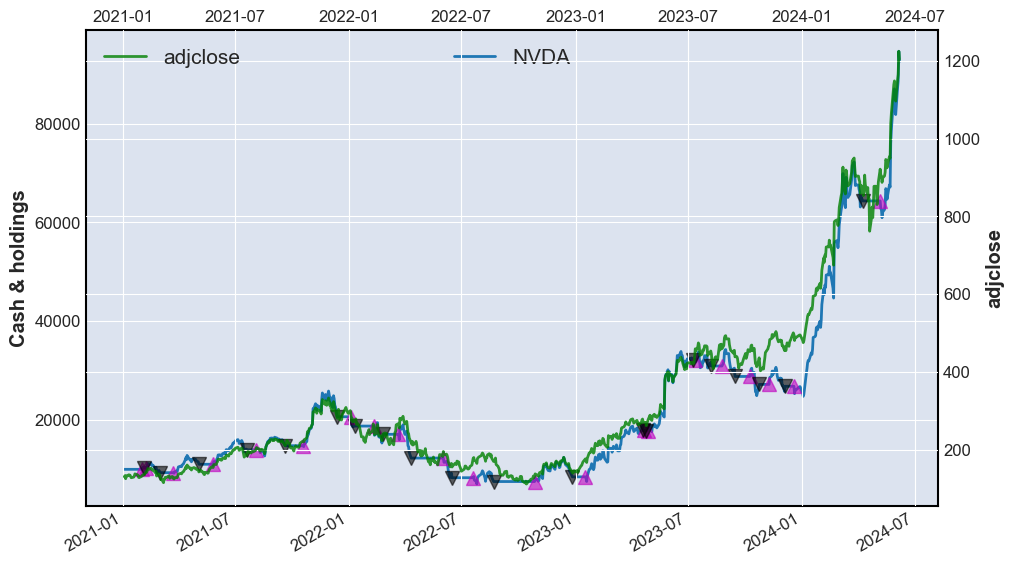

In [13]:
# visualize the portfolio value & returns >>>

# Create a figure
fig = plt.figure(figsize=(11,7))

ax1 = fig.add_subplot(111, ylabel='Cash & holdings')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2., label=tcr)
plt.legend(loc='upper center', fontsize=15)

ax1.plot(portfolio.loc[df.positions == 1.0].index, 
         portfolio.total[df.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.6)
ax1.plot(portfolio.loc[df.positions == -1.0].index, 
         portfolio.total[df.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.6)
#show="Rc"
show="adjclose"
ax2=fig.add_subplot(111, ylabel=show, frame_on=False)
ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.yaxis.set_label_position('right')
#ax2.plot(portfolio[show],color='g',alpha=0.8,label=show)
ax2.plot(df[show], color='g', alpha=0.8, label=show)
plt.legend(loc='upper left', fontsize=15)

In [14]:
'''
Далее индикатор тестируется на исторических данных.
 При этом происходит перебор всех параметров
 выбранных индикаторов с определенным шагом.
 То есть не просто периоды, к примеру,
 двух скользящих средних 10/20 проверить,
 а перебрать период первой, к примеру, от 5 до 50 с шагом 1,
 перебирая период второй скользящей средней от 10 до 100,
 к примеру, с шагом 2. Шаг хорошо бы тоже установить.
'''
# range(start, stop, step)

for short in range(5, 51, 1):
    print(short, end=' ')

5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 

In [15]:
for short in range(5, 51, 1):
  print('\n',short)
  for long in range(10, 101, 2):
    print(long, end=' ')


 5
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 6
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 7
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 8
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 9
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 10
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 11
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 1

In [16]:
## calculate index range >>
i=0
for short in range(5, 51, 1):
  print('\n',short)
  for long in range(short+3, 101, 2):
    print(long, end=' ')
    i+=1

## create DataFrame >>
dft = pd.DataFrame(index=range(i))
dft['short']=0
dft['long']=0
dft['total']=0


 5
8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 6
9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81 83 85 87 89 91 93 95 97 99 
 7
10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 8
11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81 83 85 87 89 91 93 95 97 99 
 9
12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 10
13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49 51 53 55 57 59 61 63 65 67 69 71 73 75 77 79 81 83 85 87 89 91 93 95 97 99 
 11
14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 
 12
15 17 19 21 

In [17]:
# CopyWarning: >>>
# "A value is trying to be set on a copy of a slice from a DataFrame"
warnings.filterwarnings("ignore")

i=0
for short in range(5, 51, 1):
  for long in range(short+3, 101, 2):
    dft['short'].loc[i]=short
    dft['long'].loc[i]=long

    df['fast']=ta.trend.sma_indicator(df[price], window=short)
    df['slow']=ta.trend.sma_indicator(df[price], window=long)
    # initialize `signal` column
    df['signal'] = 0.0
    # create signals
    df['signal'][short:] = np.where(df['fast'][short:] 
                                > df['slow'][short:],
                                1.0, 0.0)   
    # generate trading orders
    # Create a DataFrame `positions`
    positions = pd.DataFrame(index=df.index)
    positions[tcr] = spd*df.signal
    # Initialize the portfolio with value owned, column *tcr*
    # (store the market value of an open position) 
    portfolio = positions.multiply(df[price], axis=0)
    # Store the difference in shares owned
    # (= +- *spd* in days when position was changed)
    pos_diff = positions.diff()
    # `holdings` in portfolio
    # .sum(axis=1) --- сумма элементов в строках после умножения
    portfolio['holdings'] = (positions.multiply(df[price],
                                            axis=0)).sum(axis=1)
    # `cash` in portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(df[price],
                                                         axis=0)).sum(axis=1).cumsum()   
    # `total` portfolio
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    dft['total'].loc[i]=portfolio['total'].iloc[-1]
    i+=1
    
    print('>>> Windows ',short,' :',long,
          '  ->', portfolio['total'].iloc[-1])

warnings.filterwarnings("default")


>>> Windows  5  : 8   -> 87009.88464355469
>>> Windows  5  : 10   -> 93249.1569519043
>>> Windows  5  : 12   -> 104236.82708740234
>>> Windows  5  : 14   -> 110531.16302490234
>>> Windows  5  : 16   -> 104417.90008544922
>>> Windows  5  : 18   -> 113609.06753540039
>>> Windows  5  : 20   -> 109605.20248413086
>>> Windows  5  : 22   -> 108731.63833618164
>>> Windows  5  : 24   -> 107069.85473632812
>>> Windows  5  : 26   -> 110264.56451416016
>>> Windows  5  : 28   -> 101165.66619873047
>>> Windows  5  : 30   -> 94606.91986083984
>>> Windows  5  : 32   -> 98402.1484375
>>> Windows  5  : 34   -> 99715.87524414062
>>> Windows  5  : 36   -> 101568.98498535156
>>> Windows  5  : 38   -> 102695.30487060547
>>> Windows  5  : 40   -> 100668.408203125
>>> Windows  5  : 42   -> 100781.80541992188
>>> Windows  5  : 44   -> 92667.80853271484
>>> Windows  5  : 46   -> 93198.50158691406
>>> Windows  5  : 48   -> 95868.41430664062
>>> Windows  5  : 50   -> 99555.03845214844
>>> Windows  5  : 52   -> 1

>>> Windows  9  : 42   -> 94071.9482421875
>>> Windows  9  : 44   -> 93615.2114868164
>>> Windows  9  : 46   -> 96584.52911376953
>>> Windows  9  : 48   -> 99461.38763427734
>>> Windows  9  : 50   -> 96426.06201171875
>>> Windows  9  : 52   -> 96130.56030273438
>>> Windows  9  : 54   -> 92702.96936035156
>>> Windows  9  : 56   -> 95513.07830810547
>>> Windows  9  : 58   -> 100020.37811279297
>>> Windows  9  : 60   -> 108356.81457519531
>>> Windows  9  : 62   -> 102664.95819091797
>>> Windows  9  : 64   -> 106132.4478149414
>>> Windows  9  : 66   -> 103527.7359008789
>>> Windows  9  : 68   -> 103945.08819580078
>>> Windows  9  : 70   -> 104203.86047363281
>>> Windows  9  : 72   -> 103429.22668457031
>>> Windows  9  : 74   -> 101896.27838134766
>>> Windows  9  : 76   -> 102218.61724853516
>>> Windows  9  : 78   -> 100758.77838134766
>>> Windows  9  : 80   -> 102650.25787353516
>>> Windows  9  : 82   -> 102595.32470703125
>>> Windows  9  : 84   -> 103174.27825927734
>>> Windows  9  : 86  

>>> Windows  13  : 64   -> 102674.96795654297
>>> Windows  13  : 66   -> 103379.5669555664
>>> Windows  13  : 68   -> 102257.13653564453
>>> Windows  13  : 70   -> 100392.00286865234
>>> Windows  13  : 72   -> 98897.6791381836
>>> Windows  13  : 74   -> 99882.7896118164
>>> Windows  13  : 76   -> 101482.57141113281
>>> Windows  13  : 78   -> 100880.11169433594
>>> Windows  13  : 80   -> 100631.44073486328
>>> Windows  13  : 82   -> 102485.95428466797
>>> Windows  13  : 84   -> 102572.78594970703
>>> Windows  13  : 86   -> 104428.98712158203
>>> Windows  13  : 88   -> 104296.8734741211
>>> Windows  13  : 90   -> 104583.85314941406
>>> Windows  13  : 92   -> 105795.61004638672
>>> Windows  13  : 94   -> 103787.73040771484
>>> Windows  13  : 96   -> 106994.3115234375
>>> Windows  13  : 98   -> 106552.23541259766
>>> Windows  13  : 100   -> 109118.03741455078
>>> Windows  14  : 17   -> 93119.01779174805
>>> Windows  14  : 19   -> 91318.66226196289
>>> Windows  14  : 21   -> 94334.197235107

>>> Windows  18  : 45   -> 85211.85302734375
>>> Windows  18  : 47   -> 91453.3676147461
>>> Windows  18  : 49   -> 97761.17401123047
>>> Windows  18  : 51   -> 98859.79919433594
>>> Windows  18  : 53   -> 89819.63653564453
>>> Windows  18  : 55   -> 89548.21472167969
>>> Windows  18  : 57   -> 95404.52728271484
>>> Windows  18  : 59   -> 98896.37298583984
>>> Windows  18  : 61   -> 105109.6923828125
>>> Windows  18  : 63   -> 104035.95733642578
>>> Windows  18  : 65   -> 103818.53637695312
>>> Windows  18  : 67   -> 103822.45483398438
>>> Windows  18  : 69   -> 103887.95928955078
>>> Windows  18  : 71   -> 102783.9126586914
>>> Windows  18  : 73   -> 104934.12780761719
>>> Windows  18  : 75   -> 105203.173828125
>>> Windows  18  : 77   -> 107206.08673095703
>>> Windows  18  : 79   -> 109310.67810058594
>>> Windows  18  : 81   -> 108321.06018066406
>>> Windows  18  : 83   -> 108075.44555664062
>>> Windows  18  : 85   -> 110072.43957519531
>>> Windows  18  : 87   -> 108653.30047607422
>

>>> Windows  23  : 56   -> 95854.23583984375
>>> Windows  23  : 58   -> 101520.9701538086
>>> Windows  23  : 60   -> 105723.02703857422
>>> Windows  23  : 62   -> 107782.02362060547
>>> Windows  23  : 64   -> 108374.31182861328
>>> Windows  23  : 66   -> 106980.9341430664
>>> Windows  23  : 68   -> 107855.13000488281
>>> Windows  23  : 70   -> 106943.74237060547
>>> Windows  23  : 72   -> 108566.71295166016
>>> Windows  23  : 74   -> 109941.39251708984
>>> Windows  23  : 76   -> 108543.09692382812
>>> Windows  23  : 78   -> 108728.06854248047
>>> Windows  23  : 80   -> 110348.87084960938
>>> Windows  23  : 82   -> 110015.55633544922
>>> Windows  23  : 84   -> 111746.37603759766
>>> Windows  23  : 86   -> 112170.47119140625
>>> Windows  23  : 88   -> 112580.1986694336
>>> Windows  23  : 90   -> 114807.6187133789
>>> Windows  23  : 92   -> 113549.56359863281
>>> Windows  23  : 94   -> 113432.29675292969
>>> Windows  23  : 96   -> 111726.57318115234
>>> Windows  23  : 98   -> 110045.65429

>>> Windows  28  : 91   -> 115768.49975585938
>>> Windows  28  : 93   -> 114867.32025146484
>>> Windows  28  : 95   -> 111570.2133178711
>>> Windows  28  : 97   -> 110099.87182617188
>>> Windows  28  : 99   -> 112214.95666503906
>>> Windows  29  : 32   -> 92180.53741455078
>>> Windows  29  : 34   -> 90679.99267578125
>>> Windows  29  : 36   -> 93955.28564453125
>>> Windows  29  : 38   -> 83317.56439208984
>>> Windows  29  : 40   -> 86800.87585449219
>>> Windows  29  : 42   -> 83627.68173217773
>>> Windows  29  : 44   -> 87220.73440551758
>>> Windows  29  : 46   -> 81508.03756713867
>>> Windows  29  : 48   -> 78598.37951660156
>>> Windows  29  : 50   -> 83040.7943725586
>>> Windows  29  : 52   -> 81968.91479492188
>>> Windows  29  : 54   -> 84865.23818969727
>>> Windows  29  : 56   -> 82967.79098510742
>>> Windows  29  : 58   -> 83615.087890625
>>> Windows  29  : 60   -> 96153.66668701172
>>> Windows  29  : 62   -> 109507.80639648438
>>> Windows  29  : 64   -> 110285.85510253906
>>> Win

>>> Windows  34  : 83   -> 110945.13092041016
>>> Windows  34  : 85   -> 112150.68969726562
>>> Windows  34  : 87   -> 109723.98681640625
>>> Windows  34  : 89   -> 110229.00390625
>>> Windows  34  : 91   -> 114133.52966308594
>>> Windows  34  : 93   -> 116303.72772216797
>>> Windows  34  : 95   -> 115331.69860839844
>>> Windows  34  : 97   -> 117684.41772460938
>>> Windows  34  : 99   -> 116558.70819091797
>>> Windows  35  : 38   -> 94712.74719238281
>>> Windows  35  : 40   -> 92686.11297607422
>>> Windows  35  : 42   -> 77610.9733581543
>>> Windows  35  : 44   -> 80095.63522338867
>>> Windows  35  : 46   -> 79468.67141723633
>>> Windows  35  : 48   -> 78700.55847167969
>>> Windows  35  : 50   -> 76548.81286621094
>>> Windows  35  : 52   -> 77167.94891357422
>>> Windows  35  : 54   -> 79179.89349365234
>>> Windows  35  : 56   -> 85625.90789794922
>>> Windows  35  : 58   -> 84279.70886230469
>>> Windows  35  : 60   -> 86000.74615478516
>>> Windows  35  : 62   -> 99860.65063476562
>>> W

>>> Windows  41  : 62   -> 108137.353515625
>>> Windows  41  : 64   -> 114318.7629699707
>>> Windows  41  : 66   -> 114420.76187133789
>>> Windows  41  : 68   -> 112083.46328735352
>>> Windows  41  : 70   -> 111969.20700073242
>>> Windows  41  : 72   -> 111404.15878295898
>>> Windows  41  : 74   -> 113684.93576049805
>>> Windows  41  : 76   -> 116233.58001708984
>>> Windows  41  : 78   -> 114712.21923828125
>>> Windows  41  : 80   -> 113724.57275390625
>>> Windows  41  : 82   -> 111863.61694335938
>>> Windows  41  : 84   -> 114214.76593017578
>>> Windows  41  : 86   -> 114923.28186035156
>>> Windows  41  : 88   -> 114671.11511230469
>>> Windows  41  : 90   -> 115602.62756347656
>>> Windows  41  : 92   -> 117483.09631347656
>>> Windows  41  : 94   -> 116830.1528930664
>>> Windows  41  : 96   -> 114760.04180908203
>>> Windows  41  : 98   -> 113801.07727050781
>>> Windows  41  : 100   -> 113713.24768066406
>>> Windows  42  : 45   -> 79902.72521972656
>>> Windows  42  : 47   -> 77459.03854

>>> Windows  48  : 89   -> 118617.96875
>>> Windows  48  : 91   -> 121136.90948486328
>>> Windows  48  : 93   -> 124361.26251220703
>>> Windows  48  : 95   -> 124793.64166259766
>>> Windows  48  : 97   -> 122788.12561035156
>>> Windows  48  : 99   -> 122133.40606689453
>>> Windows  49  : 52   -> 83942.2866821289
>>> Windows  49  : 54   -> 90646.47979736328
>>> Windows  49  : 56   -> 99214.35852050781
>>> Windows  49  : 58   -> 114605.09338378906
>>> Windows  49  : 60   -> 116456.2271118164
>>> Windows  49  : 62   -> 120161.06872558594
>>> Windows  49  : 64   -> 121800.38681030273
>>> Windows  49  : 66   -> 122478.04183959961
>>> Windows  49  : 68   -> 119804.31671142578
>>> Windows  49  : 70   -> 122202.30865478516
>>> Windows  49  : 72   -> 122458.21838378906
>>> Windows  49  : 74   -> 123334.12475585938
>>> Windows  49  : 76   -> 117558.53881835938
>>> Windows  49  : 78   -> 116488.16986083984
>>> Windows  49  : 80   -> 117065.14282226562
>>> Windows  49  : 82   -> 118008.92028808594

,short,long,total
0,5,8,87009.884644
1,5,10,93249.156952
2,5,12,104236.827087
3,5,14,110531.163025
4,5,16,104417.900085
...,...,...,...
1628,50,91,126437.211609
1629,50,93,126868.737793
1630,50,95,125171.119690
1631,50,97,123586.274719


<Axes: >

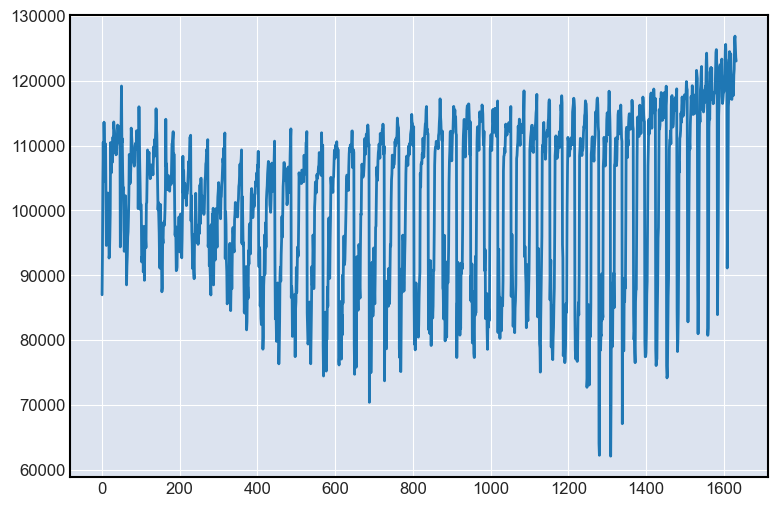

In [18]:
display(dft)

fig = plt.figure(figsize=(9,6))
dft['total'].plot()

In [19]:
#
## run if it was not before  >>
# (for saving data to file)

# initializing tcl/tk interpreter >>
window = tk.Tk()
# open filedialog window on top of other windows >>
window.wm_attributes('-topmost', 1)
# this will close empty tk-window after filedialog >>
window.withdraw()


''

In [20]:
## idea from "make_finance_panel.py" >>
def save_xls(dfall, case):
  if case=="xlsx":
    print('\nSaving data in\n', SfileName, '\n')
    dfall.to_excel(SfileName, index=False)
  elif case=="xls":
    print('\nSaving data in\n', SfileName, '\n')
    dfall.to_excel(SfileName.replace(".xls",".xlsx"), index=False)
  else:
    print('\nSaving data in\n', SfileName + ".xlsx", '\n')
    dfall.to_excel(SfileName + ".xlsx", index=False)

In [21]:
#
## Saving data to file >>
#
SfileName = filedialog.asksaveasfilename(title="Select file",
                    filetypes=(("Excel files",
                                "*.xlsx *.xls"),
                               ("All files", "*.*")),
                    parent=window)

## nice work with file extension >>
save_xls(dft, SfileName.split('.')[-1])
'''
## simple run instead of "save_xls" >>
print('\nSaving data in\n', SfileName + ".xlsx")
dft.to_excel(SfileName + ".xlsx")
'''


Saving data in
 C:/Users/mixas/trading_portfolio/tmp.xlsx 



'\n## simple run instead of "save_xls" >>\nprint(\'\nSaving data in\n\', SfileName + ".xlsx")\ndft.to_excel(SfileName + ".xlsx")\n'

In [22]:
#
## find max profit >>>
#
dft['total'].max()

ind=dft.index[ dft['total']==dft['total'].max() ][0]
short=dft.short[ind]
long=dft.long[ind]

print('\n>>> Windows', short,' :', long,
      '  ->',dft.total[ind])


>>> Windows 50  : 93   -> 126868.73779296875



>>> Windows  50  : 93   -> 126868.73779296875 



C:\Users\mixas\AppData\Local\Temp\ipykernel_10040\2772845084.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signal'][short:] = np.where(df['fast'][short:] > df['slow'][short:],


<Axes: >

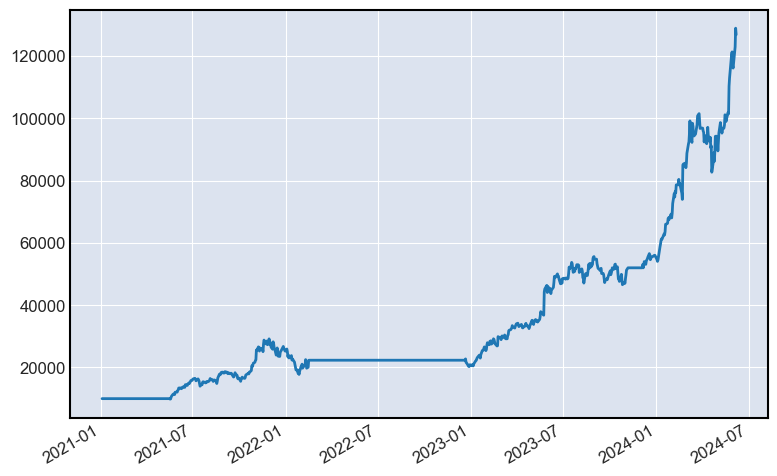

In [23]:
## trading with max profit >>>

df['fast']=ta.trend.sma_indicator(df[price], window=short)
df['slow']=ta.trend.sma_indicator(df[price], window=long)
# initialize `signal` column
df['signal'] = 0.0
# create signals
df['signal'][short:] = np.where(df['fast'][short:] > df['slow'][short:],
                            1.0, 0.0)   
# generate trading orders
df['positions'] = df['signal'].diff()    
# Create a DataFrame `positions`
positions = pd.DataFrame(index=df.index)
positions[tcr] = spd*df.signal
# Initialize the portfolio with value owned, column *tcr*
# (store the market value of an open position) 
portfolio = positions.multiply(df[price], axis=0)
# Store the difference in shares owned
# (= +- *spd* in days when position was changed)
pos_diff = positions.diff()
# `holdings` in portfolio
# .sum(axis=1) --- сумма элементов в строках после умножения
portfolio['holdings'] = (positions.multiply(df[price],
                                        axis=0)).sum(axis=1)
# `cash` in portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(df[price],
                                                     axis=0)).sum(axis=1).cumsum()   
# `total` portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

print('\n>>> Windows ',short,' :',long,
      '  ->', portfolio['total'].iloc[-1], '\n')
#%%
fig = plt.figure(figsize=(9,6))
portfolio['total'].plot()

In [24]:
#
## benchmarking
#

tcrspy="SPY"
dfspy=si.get_data(tcrspy, interval='1d', start_date=start)
print('\n', dfspy.columns, '\n\n', dfspy.index)


 Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object') 

 DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-11', '2021-01-12', '2021-01-13',
               '2021-01-14', '2021-01-15',
               ...
               '2024-05-23', '2024-05-24', '2024-05-28', '2024-05-29',
               '2024-05-30', '2024-05-31', '2024-06-03', '2024-06-04',
               '2024-06-05', '2024-06-06'],
              dtype='datetime64[ns]', length=862, freq=None)


In [25]:
dfspy['R'] = dfspy[price].pct_change()
# cumulative returns >>
dfspy["Rc"] = (dfspy.R + 1).cumprod()

ind = portfolio[portfolio['holdings']>0].index.min()
invest = portfolio['holdings'].loc[ind]
print('\nFirst purchase was ', invest,' in', ind)

dfspy["tot_spy"] = initial_capital-invest + invest*dfspy["Rc"]
dfspy.tot_spy.iloc[0] = initial_capital

print('\n', dfspy)


First purchase was  14137.860107421875  in 2021-05-17 00:00:00

                   open        high         low       close    adjclose  \
2021-01-04  375.309998  375.450012  364.820007  368.790009  351.674469   
2021-01-05  368.100006  372.500000  368.049988  371.329987  354.096558   
2021-01-06  369.709991  376.980011  369.119995  373.549988  356.213593   
2021-01-07  376.100006  379.899994  375.910004  379.100006  361.506012   
2021-01-08  380.589996  381.489990  377.100006  381.260010  363.565765   
...                ...         ...         ...         ...         ...   
2024-05-31  523.590027  527.500000  518.359985  527.369995  527.369995   
2024-06-03  529.020020  529.309998  522.599976  527.799988  527.799988   
2024-06-04  526.460022  529.150024  524.960022  528.390015  528.390015   
2024-06-05  530.770020  534.690002  528.729980  534.669983  534.669983   
2024-06-06  534.979980  535.419983  532.679993  534.549988  534.549988   

               volume ticker         R       

C:\Users\mixas\AppData\Local\Temp\ipykernel_10040\1423979309.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfspy.tot_spy.iloc[0] = initial_capital



>>> SMA windows  50  : 93


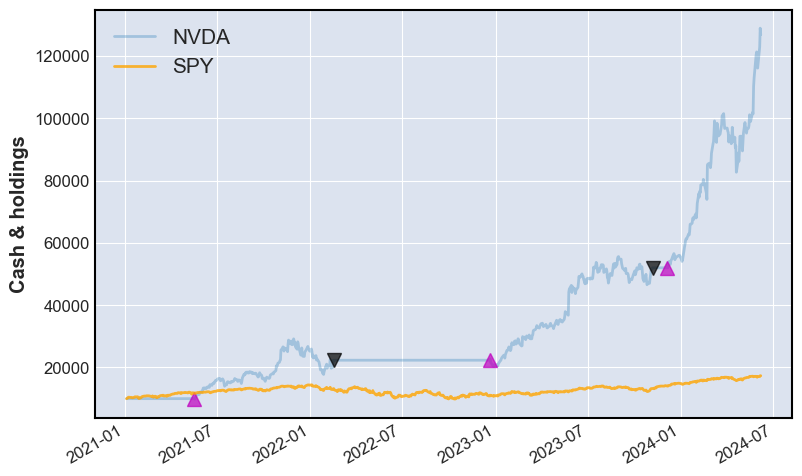

In [26]:
print('\n>>> SMA windows ',short,' :',long)

# Cash & trading vs SPY investment >>>

fig = plt.figure(figsize=(9,6))

ax1 = fig.add_subplot(111, ylabel='Cash & holdings')

portfolio['total'].plot(ax=ax1, lw=2., alpha=0.3, label=tcr)

ax1.plot(portfolio.loc[df.positions == 1.0].index, 
         portfolio.total[df.positions == 1.0],
         '^', markersize=10, color='m', alpha=0.7)
ax1.plot(portfolio.loc[df.positions == -1.0].index, 
         portfolio.total[df.positions == -1.0],
         'v', markersize=10, color='k', alpha=0.7)

ax1.plot(dfspy["tot_spy"], color='orange', alpha=0.8,
         label=tcrspy)
plt.legend(loc='best', fontsize=15)


In [27]:
!pip install pybind11
!pip install cvxpy
!pip install riskfolio-lib==3.0.1

  Obtaining dependency information for pybind11 from https://files.pythonhosted.org/packages/26/55/e776489172f576b782e616f58273e1f3de56a91004b0d20504169dd345af/pybind11-2.12.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/235.0 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/235.0 kB ? eta -:--:--
   ----------------------------- ---------- 174.1/235.0 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 235.0/235.0 kB 2.4 MB/s eta 0:00:00


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7a9139a90>
C:\Users\mixas\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=8>
  return process_handler(cmd, _system_body)
C:\Users\mixas\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=9>
  return process_handler(cmd, _system_body)
C:\Users\mixas\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=10>
  return process_handler(cmd, _system_body)


  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/69/b1/6b587306fdd7176e1e3e49c4475e6987c99439d89a140dce5632d59ffd68/cvxpy-1.5.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for osqp>=0.6.2 from https://files.pythonhosted.org/packages/3c/cc/573a38f9a58424fe0fe4e52e84614251d4740db3707834725eeb166df9ea/osqp-0.6.7-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for ecos>=2 from https://files.pythonhosted.org/packages/67/1f/165ca12f4b3de6bd3fe8b16695013d28e88808effeff37858427ae56f449/ecos-2.0.13-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for clarabel>=0.5.0 from https://files.pythonhosted.org/packages/36/be/110fe7ca190e024e3185d6351645346b785da6933ce3fb382d4811215f8c/clarabel-0.9.0-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for scs>=3.2.4.post1 from https://files.pythonhosted.org/packages/56/fa/02fbaacc782f538e3b4987a6eb01c26e8d75648e5a50149f27a62c5c4f6

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7a913b770>


  Obtaining dependency information for riskfolio-lib==3.0.1 from https://files.pythonhosted.org/packages/28/01/81f7ec41166cb3e2ccc9e028f524e5aaa2540b88c27cf3ab56791e2d6a74/Riskfolio_Lib-3.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for xlsxwriter>=1.3.7 from https://files.pythonhosted.org/packages/a7/ea/53d1fe468e63e092cf16e2c18d16f50c29851242f9dd12d6a66e0d7f0d02/XlsxWriter-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/88.6 kB ? eta -:--:--
   ------------- -------------------------- 30.7/88.6 kB ? eta -:--:--
   ---------------------------------------- 88.6/88.6 kB 1.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/159.9 kB ? eta -:--:--
   ------------------------------ --------- 122.9/159.9 kB 7.5 MB/s eta 0:00:01
   ---------------------------------------- 159.9/159.9 kB 3.2 MB/s eta 0:00:00


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7a913acf0>


In [28]:
!pip install mosek

  Obtaining dependency information for mosek from https://files.pythonhosted.org/packages/b7/01/168cd53392571a4a89afbe543f95d2080b05270c3d4f99f2e59672f4dd2b/Mosek-10.2.0-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/19.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.5 MB 960.0 kB/s eta 0:00:21
   ---------------------------------------- 0.1/19.5 MB 1.7 MB/s eta 0:00:12
    --------------------------------------- 0.4/19.5 MB 2.8 MB/s eta 0:00:07
   - -------------------------------------- 1.0/19.5 MB 5.1 MB/s eta 0:00:04
   ---- ----------------------------------- 2.1/19.5 MB 8.8 MB/s eta 0:00:02
   ------- -------------------------------- 3.8/19.5 MB 14.4 MB/s eta 0:00:02
   ----------- ---------------------------- 5.7/19.5 MB 18.1 MB/s eta 0:00:01
   ----------- ---------------------------- 5.7/19.5 MB 18.1 MB/s eta 0:00:01
   ------------------- -------------------- 9.6/19.5 MB 23.5 MB/s eta 0:00:01
   ----------------------- -

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7a913b230>


In [29]:
import webbrowser
import pandas as pd
import yfinance as yf
import datetime
import yahoo_fin.stock_info as si
import riskfolio as pf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Math

In [30]:
# 10 years period >>
start = str( datetime.date.today().year-10 ) + "-01-01"


In [31]:
# get most active stocks on the day
ma = si.get_day_most_active()
print('\n', ma.columns,
      '\n\n', ma[['Symbol', 'Name', 'Volume']][:40])


 Index(['Symbol', 'Name', 'Price (Intraday)', 'Change', '% Change', 'Volume',
       'Avg Vol (3 month)', 'Market Cap', 'PE Ratio (TTM)'],
      dtype='object') 

    Symbol                                   Name       Volume
0     GME                         GameStop Corp.  142010000.0
1     NIO                               NIO Inc.   75496000.0
2    TSLA                            Tesla, Inc.   60397000.0
3    NVDA                     NVIDIA Corporation   58205000.0
4    MARA        Marathon Digital Holdings, Inc.   52743000.0
5    PLTR             Palantir Technologies Inc.   51522000.0
6     AMD           Advanced Micro Devices, Inc.   41086000.0
7    NVAX                          Novavax, Inc.   35951000.0
8    HOOD                Robinhood Markets, Inc.   34434000.0
9    LYFT                             Lyft, Inc.   32265000.0
10   RIOT                   Riot Platforms, Inc.   30309000.0
11    AAL           American Airlines Group Inc.   28534000.0
12   AAPL                    

In [32]:
# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'AMD', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'INTC', 'BAX', 'BMY', 'LUV', 'PCAR', 'AAL', 'TMO',
          'DE', 'TSLA', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

In [33]:
## Downloading data (if it works) >>>
#
'''
data = yf.download(assets, start = start, end = end)
'''
data = yf.download(assets, start = start)
# keep 'Adj Close'
data = data.loc[:,'Adj Close']

[                       0%%                      ]sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6d470>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6cb40>
[***************       32%%                      ]  8 of 25 completedsys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6c670>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4ca3d90>
[*****************     36%%                      ]  9 of 25 completedsys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6c7c0>
[********************* 44%%                      ]  11 of 25 completedsys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6d320>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6c910>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6d010>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6d2b0>
sys:1: ResourceWarning

In [34]:
Y = data.pct_change().dropna()

# display format (multiplied on 100%)
pd.options.display.float_format = '{:.4%}'.format
display(Y)

pd.options.display.float_format = '{:.4f}'.format
display(Y)

pd.options.display.float_format = '{:.2%}'.format
display(Y)

Ticker,AAL,AMD,APA,BA,BAX,BMY,CMCSA,CNP,DE,HPQ,...,MO,NI,PCAR,SEE,T,TGT,TMO,TSLA,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,4.6530%,1.2658%,0.0702%,0.6951%,0.1590%,1.1097%,-0.7386%,-0.0438%,0.4432%,2.4585%,...,-0.4749%,0.5265%,0.2051%,-0.1779%,-0.4292%,0.4906%,0.3831%,-0.3598%,-1.1836%,0.7083%
2014-01-06,1.8463%,3.2500%,0.9002%,0.5740%,0.1731%,-0.3974%,-0.0979%,0.1315%,-0.8272%,-0.1765%,...,-1.1665%,1.5095%,0.9040%,-0.0891%,0.4598%,-0.6773%,0.0091%,-1.7117%,0.5576%,-0.7033%
2014-01-07,-0.4439%,1.2106%,1.8422%,1.5172%,0.5330%,-0.1520%,3.5476%,1.0508%,0.4449%,-0.3888%,...,0.0000%,0.3338%,-0.0676%,0.8621%,-0.0286%,-0.2379%,2.0443%,1.6054%,1.2528%,0.3036%
2014-01-08,2.6756%,0.0000%,-1.4220%,0.2206%,0.3296%,1.6362%,-0.1514%,-1.0399%,-1.0741%,-2.5905%,...,-0.4023%,-0.4840%,-0.2537%,0.3537%,-0.2940%,-0.3497%,1.5404%,1.2855%,-0.5536%,0.8742%
2014-01-09,6.4785%,-2.1531%,-0.6463%,0.9303%,0.2714%,3.0139%,0.2465%,1.1383%,-0.4030%,0.5829%,...,0.3232%,0.5775%,0.0509%,-0.8810%,-2.0444%,1.0369%,-0.0350%,-2.4788%,-2.0618%,0.7333%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.5245%,0.0900%,2.6909%,2.8133%,2.8666%,2.0870%,2.9843%,2.5891%,1.7402%,-4.8488%,...,1.7826%,3.8599%,1.6548%,3.1308%,3.4052%,4.1970%,0.9276%,-0.3971%,2.0332%,2.2007%
2024-06-03,0.2609%,-2.0072%,-3.5703%,3.9187%,-0.0293%,1.6549%,-1.1241%,0.7866%,-1.7718%,-3.2329%,...,0.6486%,-1.5485%,-1.8698%,1.7752%,-1.1526%,-2.0044%,0.2817%,-1.0052%,-0.4131%,-2.6858%
2024-06-04,-0.2602%,-2.1767%,-1.6304%,2.1943%,-2.2887%,-0.0479%,-0.0505%,0.2927%,0.3396%,0.0849%,...,0.6015%,1.7476%,0.4266%,1.2639%,1.8878%,-1.6206%,0.0158%,-0.8622%,1.4153%,-2.1413%


Ticker,AAL,AMD,APA,BA,BAX,BMY,CMCSA,CNP,DE,HPQ,...,MO,NI,PCAR,SEE,T,TGT,TMO,TSLA,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.0465,0.0127,0.0007,0.0070,0.0016,0.0111,-0.0074,-0.0004,0.0044,0.0246,...,-0.0047,0.0053,0.0021,-0.0018,-0.0043,0.0049,0.0038,-0.0036,-0.0118,0.0071
2014-01-06,0.0185,0.0325,0.0090,0.0057,0.0017,-0.0040,-0.0010,0.0013,-0.0083,-0.0018,...,-0.0117,0.0151,0.0090,-0.0009,0.0046,-0.0068,0.0001,-0.0171,0.0056,-0.0070
2014-01-07,-0.0044,0.0121,0.0184,0.0152,0.0053,-0.0015,0.0355,0.0105,0.0044,-0.0039,...,0.0000,0.0033,-0.0007,0.0086,-0.0003,-0.0024,0.0204,0.0161,0.0125,0.0030
2014-01-08,0.0268,0.0000,-0.0142,0.0022,0.0033,0.0164,-0.0015,-0.0104,-0.0107,-0.0259,...,-0.0040,-0.0048,-0.0025,0.0035,-0.0029,-0.0035,0.0154,0.0129,-0.0055,0.0087
2014-01-09,0.0648,-0.0215,-0.0065,0.0093,0.0027,0.0301,0.0025,0.0114,-0.0040,0.0058,...,0.0032,0.0058,0.0005,-0.0088,-0.0204,0.0104,-0.0004,-0.0248,-0.0206,0.0073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.0052,0.0009,0.0269,0.0281,0.0287,0.0209,0.0298,0.0259,0.0174,-0.0485,...,0.0178,0.0386,0.0165,0.0313,0.0341,0.0420,0.0093,-0.0040,0.0203,0.0220
2024-06-03,0.0026,-0.0201,-0.0357,0.0392,-0.0003,0.0165,-0.0112,0.0079,-0.0177,-0.0323,...,0.0065,-0.0155,-0.0187,0.0178,-0.0115,-0.0200,0.0028,-0.0101,-0.0041,-0.0269
2024-06-04,-0.0026,-0.0218,-0.0163,0.0219,-0.0229,-0.0005,-0.0005,0.0029,0.0034,0.0008,...,0.0060,0.0175,0.0043,0.0126,0.0189,-0.0162,0.0002,-0.0086,0.0142,-0.0214


Ticker,AAL,AMD,APA,BA,BAX,BMY,CMCSA,CNP,DE,HPQ,...,MO,NI,PCAR,SEE,T,TGT,TMO,TSLA,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,4.65%,1.27%,0.07%,0.70%,0.16%,1.11%,-0.74%,-0.04%,0.44%,2.46%,...,-0.47%,0.53%,0.21%,-0.18%,-0.43%,0.49%,0.38%,-0.36%,-1.18%,0.71%
2014-01-06,1.85%,3.25%,0.90%,0.57%,0.17%,-0.40%,-0.10%,0.13%,-0.83%,-0.18%,...,-1.17%,1.51%,0.90%,-0.09%,0.46%,-0.68%,0.01%,-1.71%,0.56%,-0.70%
2014-01-07,-0.44%,1.21%,1.84%,1.52%,0.53%,-0.15%,3.55%,1.05%,0.44%,-0.39%,...,0.00%,0.33%,-0.07%,0.86%,-0.03%,-0.24%,2.04%,1.61%,1.25%,0.30%
2014-01-08,2.68%,0.00%,-1.42%,0.22%,0.33%,1.64%,-0.15%,-1.04%,-1.07%,-2.59%,...,-0.40%,-0.48%,-0.25%,0.35%,-0.29%,-0.35%,1.54%,1.29%,-0.55%,0.87%
2014-01-09,6.48%,-2.15%,-0.65%,0.93%,0.27%,3.01%,0.25%,1.14%,-0.40%,0.58%,...,0.32%,0.58%,0.05%,-0.88%,-2.04%,1.04%,-0.04%,-2.48%,-2.06%,0.73%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.52%,0.09%,2.69%,2.81%,2.87%,2.09%,2.98%,2.59%,1.74%,-4.85%,...,1.78%,3.86%,1.65%,3.13%,3.41%,4.20%,0.93%,-0.40%,2.03%,2.20%
2024-06-03,0.26%,-2.01%,-3.57%,3.92%,-0.03%,1.65%,-1.12%,0.79%,-1.77%,-3.23%,...,0.65%,-1.55%,-1.87%,1.78%,-1.15%,-2.00%,0.28%,-1.01%,-0.41%,-2.69%
2024-06-04,-0.26%,-2.18%,-1.63%,2.19%,-2.29%,-0.05%,-0.05%,0.29%,0.34%,0.08%,...,0.60%,1.75%,0.43%,1.26%,1.89%,-1.62%,0.02%,-0.86%,1.42%,-2.14%


In [35]:
### Calculating portfolio that maximizes Sharpe ratio >>>
## (Mean-Variance Portfolio)

try:
  # Building the portfolio object
  port = pf.Portfolio(returns=Y)
except:
  # this is for my old version of code !!! >>>
  port = pf(returns=Y)

In [36]:
##
### Calculating portfolio, continue... >>>
##

# Select method >>
# estimate expected returns on historical data
method_mu='hist'
# estimate covariance matrix on historical data
method_cov='hist'

# estimate input parameters >>
port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov)

# Estimate optimal portfolio >>

# Could be
# Classic (historical),
# BL (Black Litterman),
# FM (Factor Model)
model='Classic'

# Risk measure used, this time will be variance
rm = 'MV'

# Objective function, could be MinRisk,
# MaxRet, Utility or Sharpe
obj = 'Sharpe'

# Use historical scenarios for risk measures
hist = True

# Risk free rate
rf = 0
# Risk aversion factor, only useful when obj is 'Utility'
l = 0

# Estimate optimal portfolio >>
w = port.optimization(model=model, rm=rm, obj=obj,
                      rf=rf, l=l, hist=hist)

# display weights
display(w)

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


,weights
AAL,0.00%
AMD,15.78%
APA,0.00%
BA,0.00%
BAX,0.00%
BMY,0.00%
CMCSA,0.00%
CNP,0.00%
DE,9.04%
HPQ,0.00%


C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:565: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)
C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:581: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


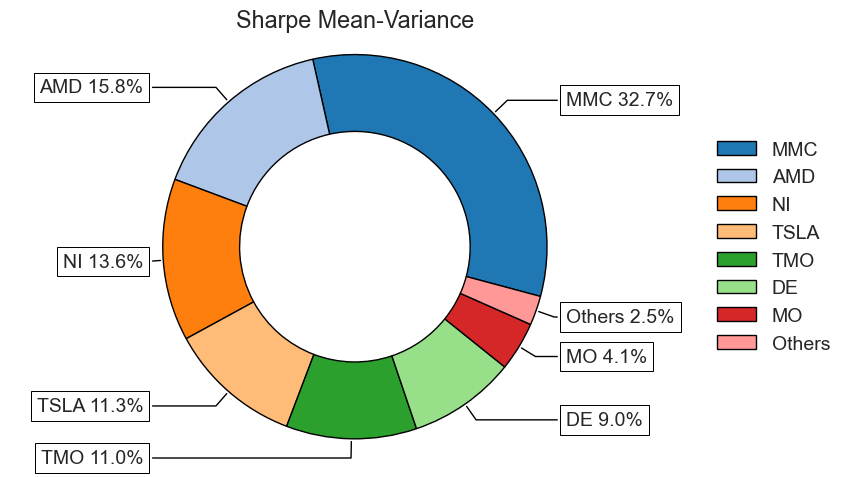

In [37]:
# Plotting portfolio composition
plt.rcParams.update({'font.size': 14})
ax = pf.plot_pie(w=w, title='Sharpe Mean-Variance',
                  others=0.05, height=5, width=8.7)

In [38]:
## Calculate efficient frontier
#

# Number of points of the frontier
points = 50
points = 5
points = 10

frontier = port.efficient_frontier(model=model, rm=rm,
                                   points=points, rf=rf,
                                   hist=hist)

display(frontier)

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
C:

,0,1,2,3,4,5,6,7,8,9
AAL,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
AMD,0.00%,12.44%,21.99%,30.77%,38.94%,47.00%,54.70%,67.79%,86.59%,100.00%
APA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BAX,7.67%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
BMY,12.89%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CMCSA,1.09%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CNP,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
DE,0.00%,7.89%,9.78%,9.10%,8.08%,6.07%,3.80%,0.00%,0.00%,0.00%
HPQ,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


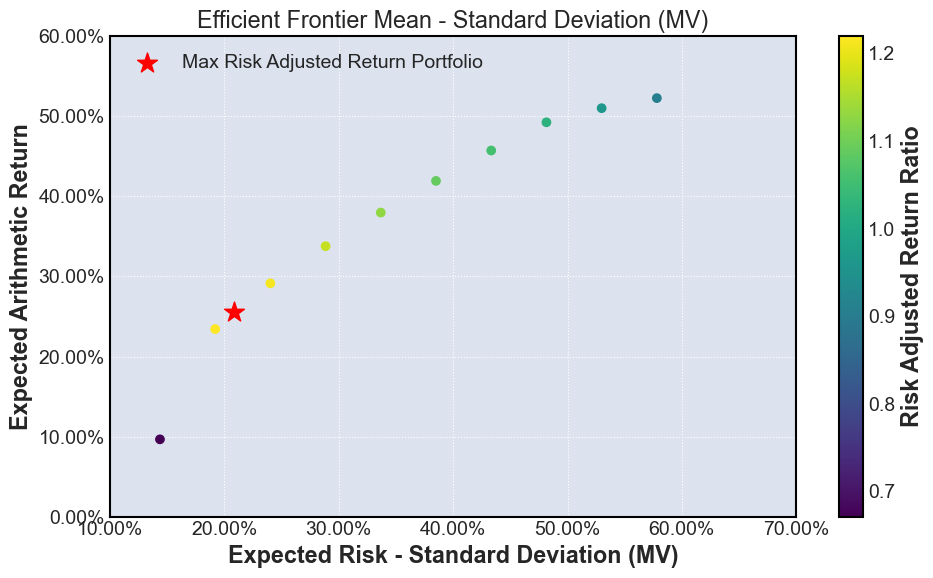

In [39]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio'
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = pf.plot_frontier(w_frontier=frontier, mu=mu, cov=cov,
                       returns=returns, rm=rm,
                       rf=rf, alpha=0.05, cmap='viridis',
                       w=w, label=label,
                       marker='*', s=15, c='r',
                       height=6, width=10)

<>:12: DeprecationWarning: invalid escape sequence '\.'
<>:12: DeprecationWarning: invalid escape sequence '\.'
C:\Users\mixas\AppData\Local\Temp\ipykernel_10040\112589490.py:12: DeprecationWarning: invalid escape sequence '\.'
  '''
C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:935: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


'\n~\\.conda\\envs\x0cinance\\lib\\site-packages\riskfolio\\src\\RiskFunctions.py:\n  587 in RLVaR_Hist\n   value = risk.value.item()\n'

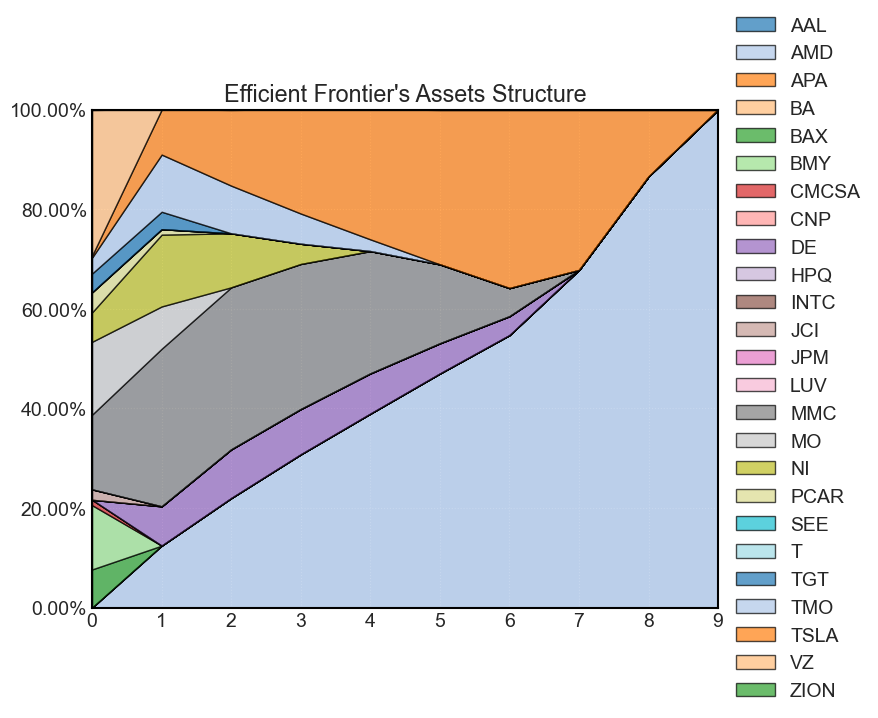

In [58]:
# Plotting efficient frontier composition
ax = pf.plot_frontier_area(w_frontier=frontier,
                            height=7, width=9)

# MSFT dominate if you increase Risk free rate in model
'''
rf = .0001
'''
#%%
## Error in Riskfolio-Lib 4.1.1 >>
## 'NoneType' object has no attribute 'item' >>
'''
~\.conda\envs\finance\lib\site-packages\riskfolio\src\RiskFunctions.py:
  587 in RLVaR_Hist
   value = risk.value.item()
'''


C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Users\mixas\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


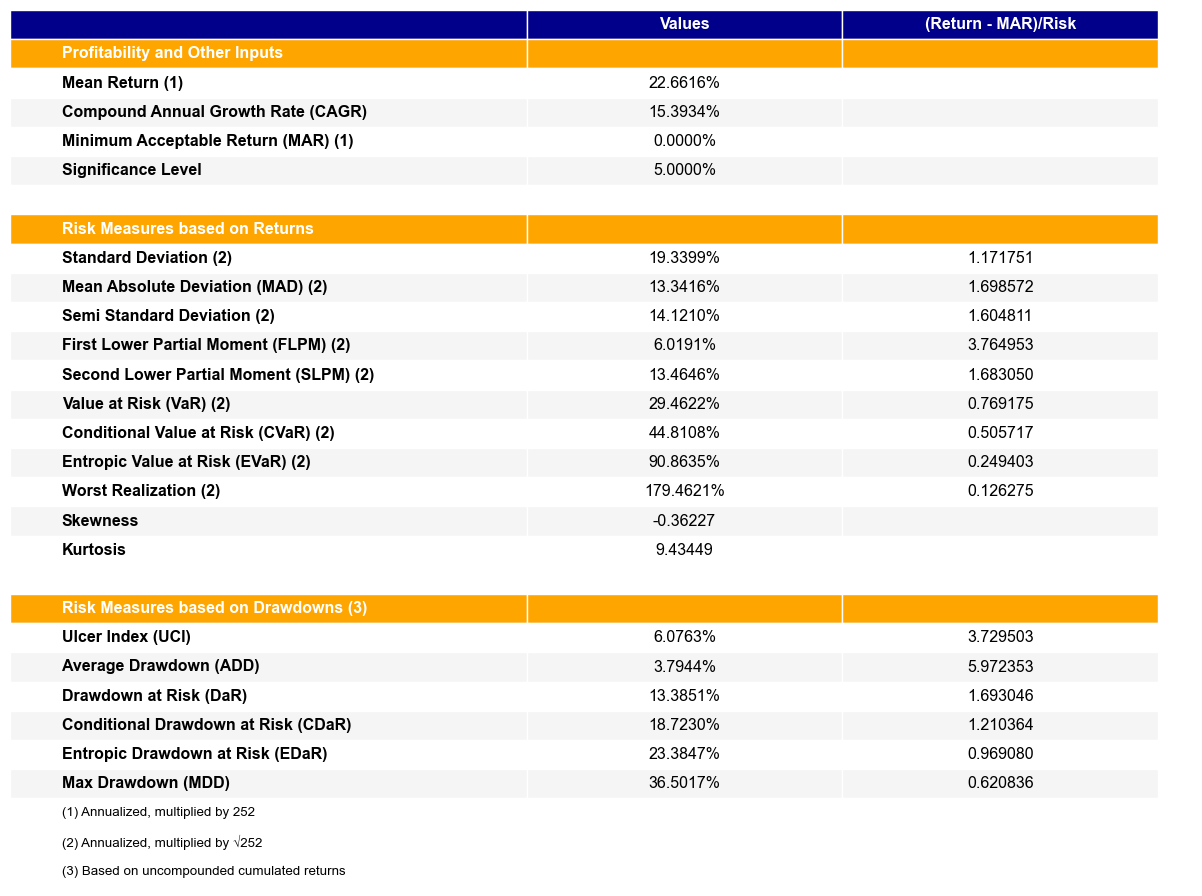

In [61]:
plt.rcParams.update({'font.size': 8})
ax = pf.plot_table(returns=Y, w=w, alpha=0.05)

C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Users\mixas\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


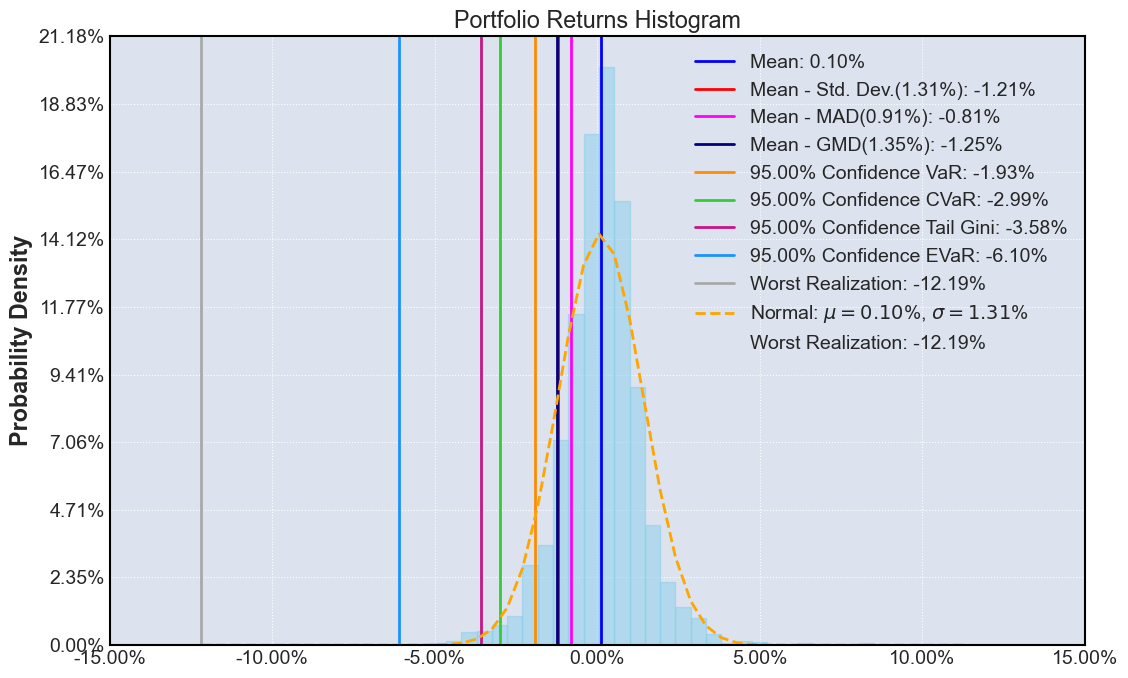

In [41]:
# histogram of portfolio returns with risk measures >>

## Error Riskfolio-Lib 4.1.1 >>
## 'NoneType' object has no attribute 'item' >>
ax = pf.plot_hist(returns=Y, w=w, alpha=0.05,
                   bins=50, height=7, width=11.5)

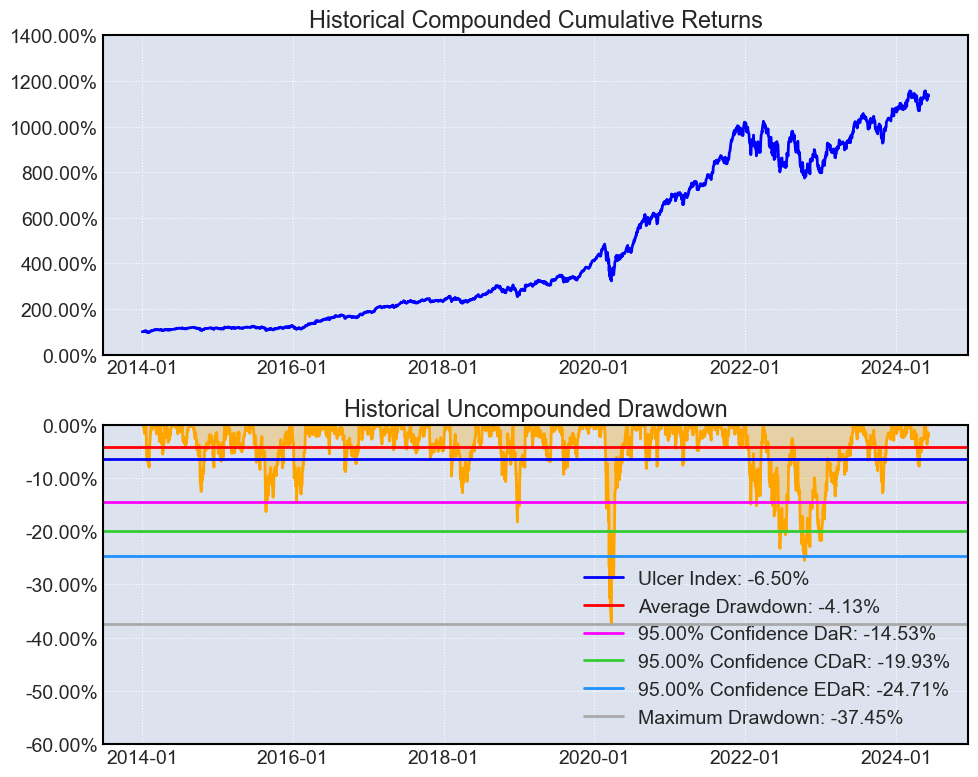

In [42]:
## evolution of portfolio prices and drawdown >>
# 'port.nav' is cumulative assets returns
ax = pf.plot_drawdown(nav=port.nav, w=w, alpha=0.05,
                       height=8, width=10)

C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:2174: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels[permutation], rotation=90, ha="center")
C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:2218: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


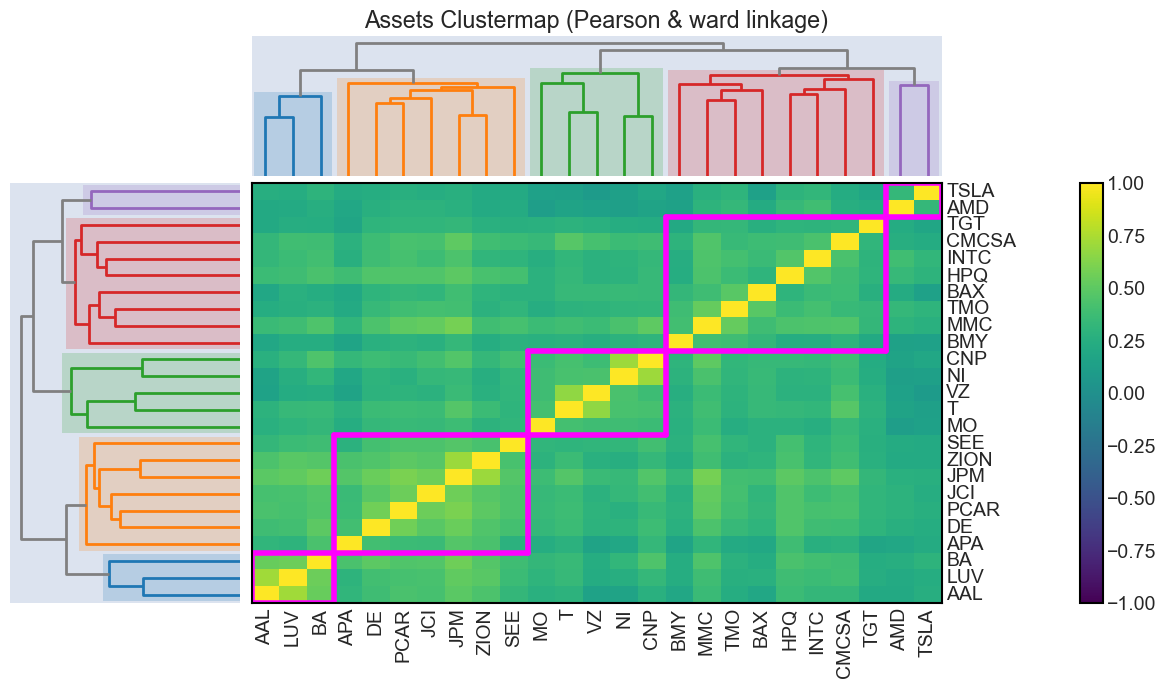

In [43]:
# clustermap plot based on codependence measure
ax = pf.plot_clusters(returns=Y, codependence='pearson',
                   linkage='ward', max_k=10, bins_info='KN',
                   alpha_tail=0.05, leaf_order=True,
                   dendrogram=True, cmap='viridis',
                   height=7, width=11.5)

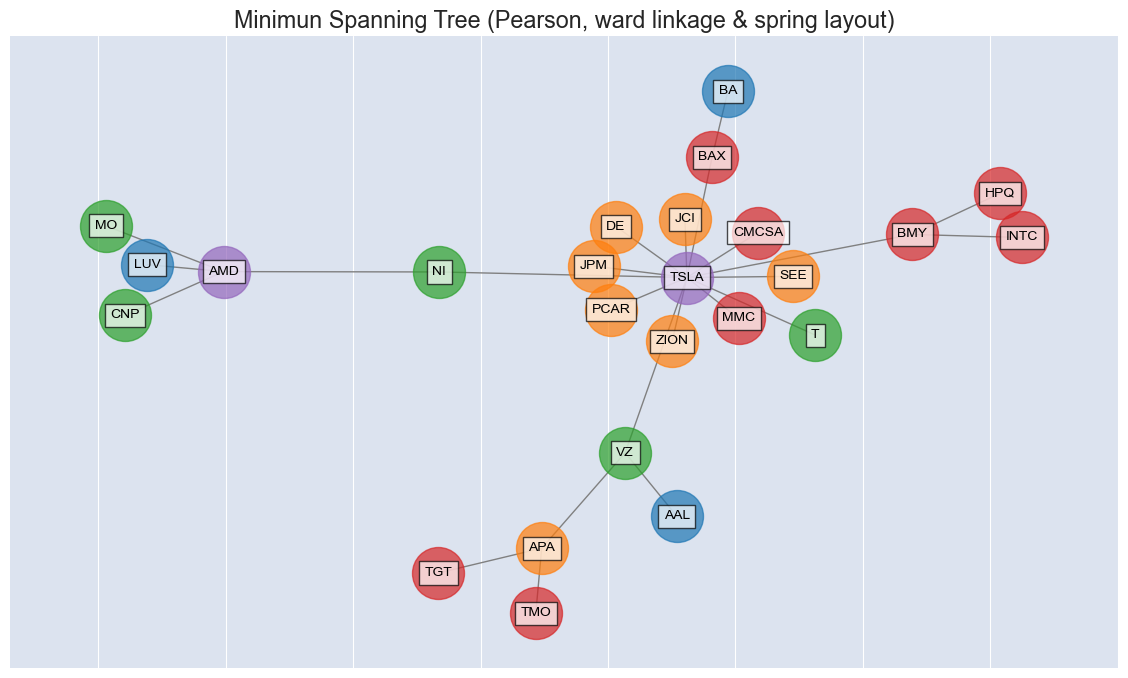

In [44]:
# MST network plot
ax = pf.plot_network(returns=Y, codependence='pearson',
                   linkage='ward', max_k=10, bins_info='KN',
                   alpha_tail=0.05, leaf_order=True,
                   kind='spring',
                   height=7, width=11.5)

In [45]:
rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
            'WR', 'MDD',  'ADD', 'CDaR',         'UCI']

In [46]:
w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj,
                          rf=rf, l=l, hist=hist)
    print(i, ' ', end="")
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


MV  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


MAD  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


MSV  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


FLPM  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


SLPM  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


CVaR  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


WR  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


MDD  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


ADD  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


CDaR  

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


UCI  

<Axes: >

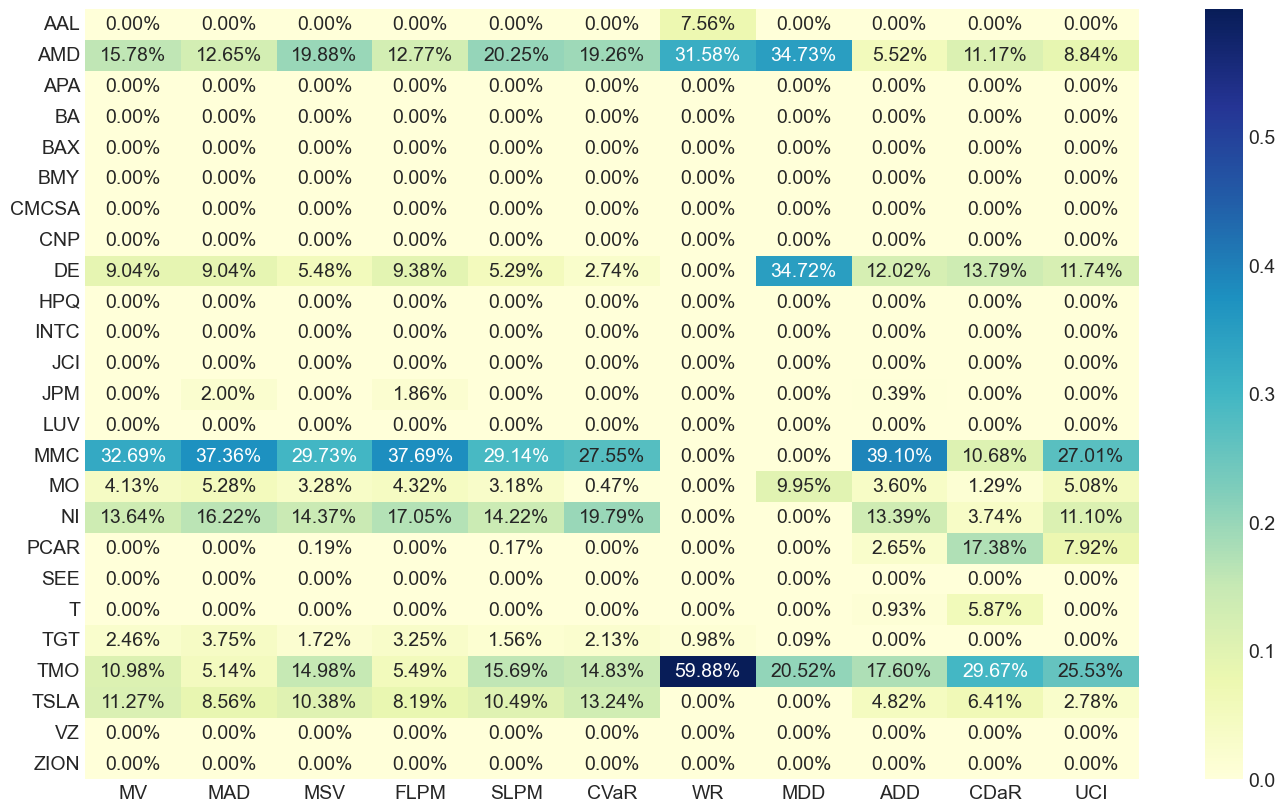

In [47]:
# display weights
f, ax = plt.subplots(figsize=(17, 10))
sns.heatmap(w_s, annot=True, fmt=".2%", cmap='YlGnBu')

<Axes: >

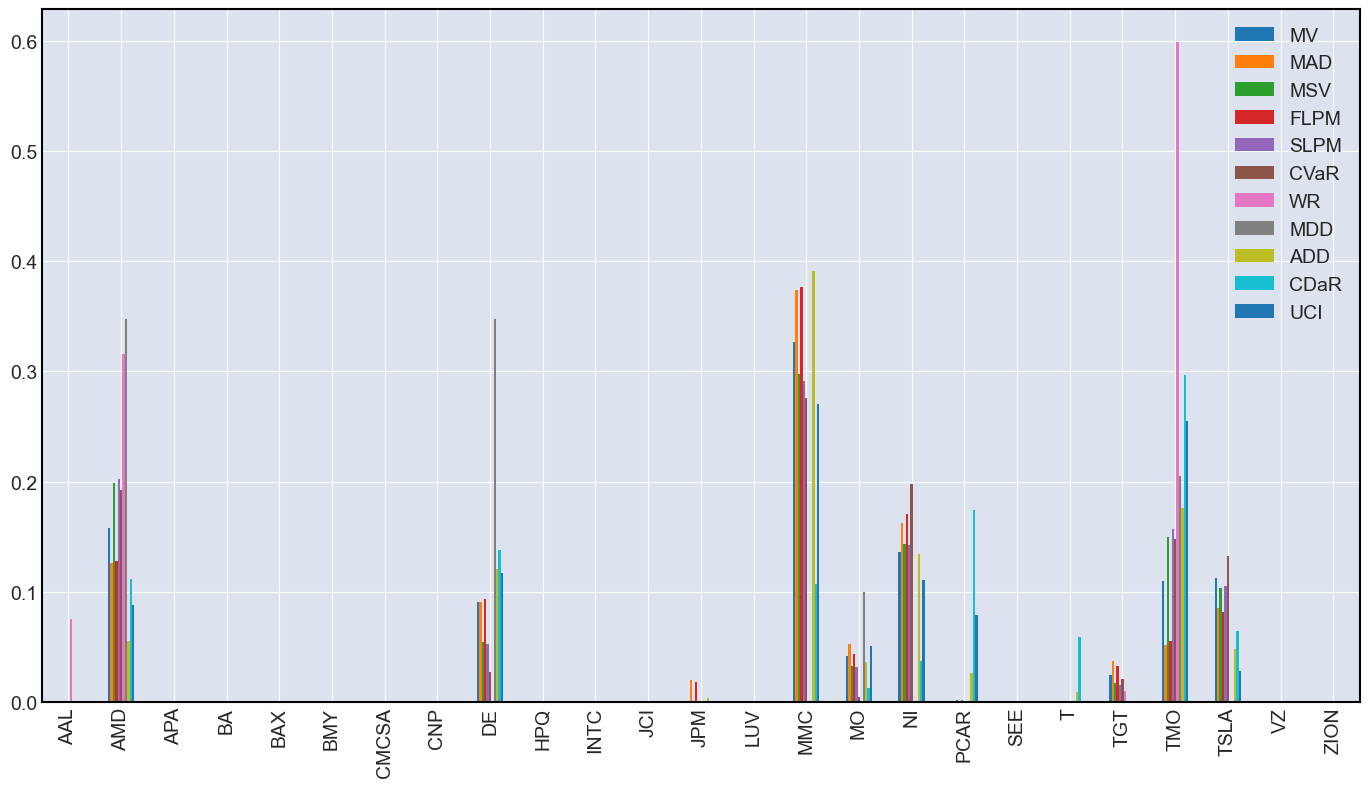

In [48]:
# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(17)
fig.set_figheight(9)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)

In [49]:
##
### Constraints on Assets and Assets Classes
##

display(Math(r'{\large \text{Constraints}: \, Aw \leq B, \\}'),
        Math(r'{\large \text{where} \, w \, \text{is vector of weights of optimum portfolio.}}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [50]:
# Creating the constraints
asset_classes = {'Assets': ['JCI', 'TGT', 'CMCSA', 'AMD', 'MO', 'APA', 'MMC', 'JPM',
                            'ZION', 'INTC', 'BAX', 'BMY', 'LUV', 'PCAR', 'AAL', 'TMO',
                            'DE', 'TSLA', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA'], 
                 'Industry': ['Consumer Discretionary','Consumer Discretionary',
                              'Consumer Discretionary', 'Information Technology',
                              'Consumer Staples','Energy','Financials',
                              'Financials',
                              'Financials','Information Technology',
                              'Health Care','Health Care','Industrials','Industrials',
                              'Transportation','Health Care',
                              'Industrials','Consumer Discretionary','Information Technology',
                              'Materials','Telecommunications Services','Utilities',
                              'Utilities','Telecommunications Services','Financials']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False],
               'Type': ['All Assets', 'Classes', 'Classes', 'Classes',
                        'Classes'],
               'Set': ['', 'Industry', 'Industry', 'Industry', 'Industry'],
               'Position': ['', 'Financials', 'Utilities', 'Industrials',
                            'Consumer Discretionary'],
               'Sign': ['<=', '<=', '<=', '<=', '<='],
               'Weight': [0.10, 0.2, 0.2, 0.2, 0.2],
               'Type Relative': ['', '', '', '', ''],
               'Relative Set': ['', '', '', '', ''],
               'Relative': ['', '', '', '', ''],
               'Factor': ['', '', '', '', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,10.00%,,,,
1,False,Classes,Industry,Financials,<=,20.00%,,,,
2,False,Classes,Industry,Utilities,<=,20.00%,,,,
3,False,Classes,Industry,Industrials,<=,20.00%,,,,
4,False,Classes,Industry,Consumer Discretionary,<=,20.00%,,,,


In [51]:
# constraints could be done in Excel
path = r"C:/Users/mixas/trading_portfolio"
constraints.to_excel(path + "constraints.xlsx", index=False)
constraints.to_csv(path + "constraints.csv", index=False)

tmp=pd.read_csv(path + "constraints.csv", header=0)
display('\n', tmp.T,'\n\n', tmp)

asset_classes.to_excel(path + "asset_classes.xlsx", index=False)
asset_classes.to_csv(path + "asset_classes.csv", index=False)

tmpcl=pd.read_csv(path + "asset_classes.csv", header=0)
display('\n', tmpcl)

'\n'

,0,1,2,3,4
Disabled,False,False,False,False,False
Type,All Assets,Classes,Classes,Classes,Classes
Set,NaN,Industry,Industry,Industry,Industry
Position,NaN,Financials,Utilities,Industrials,Consumer Discretionary
Sign,<=,<=,<=,<=,<=
Weight,10.00%,20.00%,20.00%,20.00%,20.00%
Type Relative,NaN,NaN,NaN,NaN,NaN
Relative Set,NaN,NaN,NaN,NaN,NaN
Relative,NaN,NaN,NaN,NaN,NaN
Factor,NaN,NaN,NaN,NaN,NaN


'\n\n'

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,NaN,NaN,<=,10.00%,NaN,NaN,NaN,NaN
1,False,Classes,Industry,Financials,<=,20.00%,NaN,NaN,NaN,NaN
2,False,Classes,Industry,Utilities,<=,20.00%,NaN,NaN,NaN,NaN
3,False,Classes,Industry,Industrials,<=,20.00%,NaN,NaN,NaN,NaN
4,False,Classes,Industry,Consumer Discretionary,<=,20.00%,NaN,NaN,NaN,NaN


'\n'

,Assets,Industry
0,AAL,Transportation
1,AMD,Information Technology
2,APA,Energy
3,BA,Financials
4,BAX,Health Care
5,BMY,Health Care
6,CMCSA,Consumer Discretionary
7,CNP,Utilities
8,DE,Industrials
9,HPQ,Information Technology


In [52]:
A, B = pf.ConstraintsFunctions.assets_constraints(constraints, asset_classes)
"""
# old >>
A, B = cf.assets_constraints(constraints, asset_classes)
"""
A
B

array([[-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.1],
       [-0.2],
       [-0.2],
       [-0.2],
       [-0.2]])

In [53]:
port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf,
                      l=l, hist=hist)

display(w)

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


,weights
AAL,0.00%
AMD,10.00%
APA,0.00%
BA,0.00%
BAX,0.00%
BMY,0.00%
CMCSA,0.00%
CNP,0.00%
DE,10.00%
HPQ,0.00%


C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:565: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)
C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:581: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


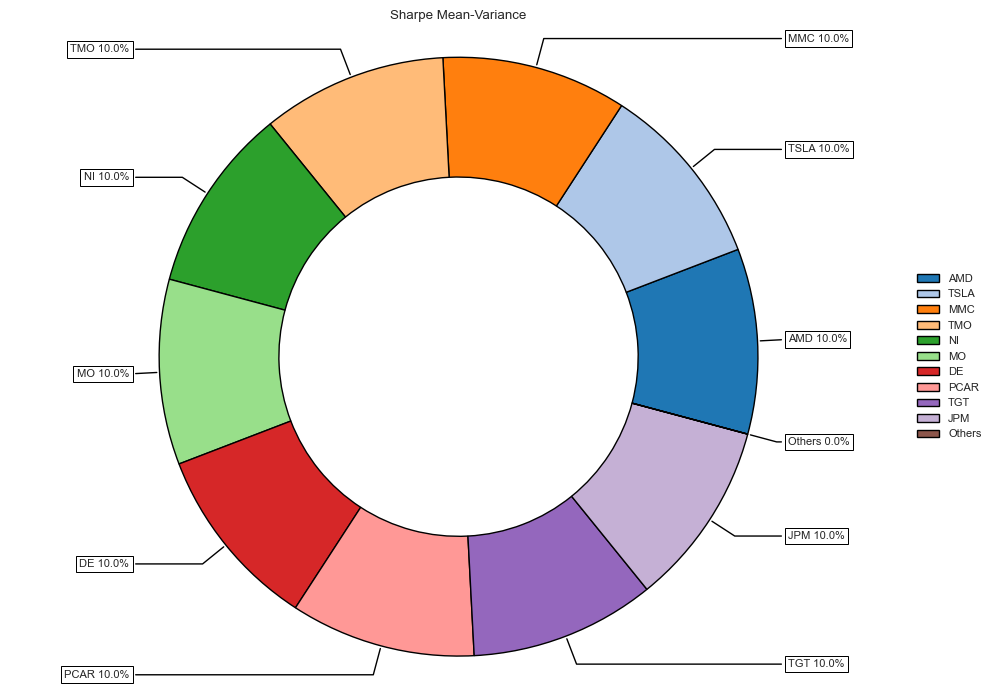

In [65]:
# Plotting portfolio composition
ax = pf.plot_pie(w=w, title='Sharpe Mean-Variance',
                  others=0.05, height=7, width=10)

In [55]:
w_classes = pd.concat([asset_classes.set_index('Assets'), w],
                      axis=1)
display(w_classes)

,Industry,weights
AAL,Transportation,0.00%
AMD,Information Technology,10.00%
APA,Energy,0.00%
BA,Financials,0.00%
BAX,Health Care,0.00%
BMY,Health Care,0.00%
CMCSA,Consumer Discretionary,0.00%
CNP,Utilities,0.00%
DE,Industrials,10.00%
HPQ,Information Technology,0.00%


In [56]:
w_classes = w_classes.groupby(['Industry']).sum()

display(w_classes)

,weights
Industry,
Consumer Discretionary,20.00%
Consumer Staples,10.00%
Energy,0.00%
Financials,20.00%
Health Care,10.00%
Industrials,20.00%
Information Technology,10.00%
Materials,0.00%
Telecommunications Services,0.00%


C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:565: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)
C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\PlotFunctions.py:581: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap(cmap)


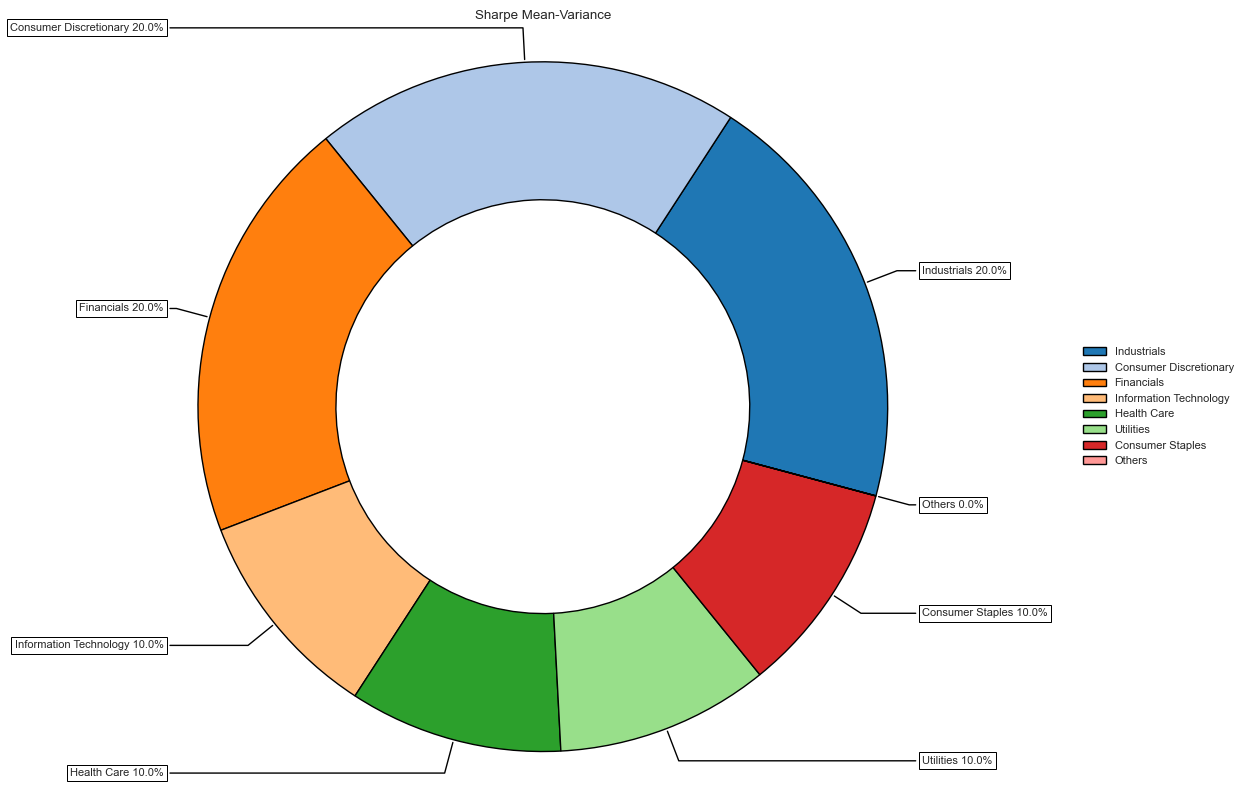

In [67]:
# Plotting portfolio composition
ax = pf.plot_pie(w=w_classes, title='Sharpe Mean-Variance',
                  others=0.05, height=8, width=12.5)

In [68]:
!pip install pybind11

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7c0469630>
C:\Users\mixas\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=8>
  return process_handler(cmd, _system_body)
C:\Users\mixas\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=9>
  return process_handler(cmd, _system_body)
C:\Users\mixas\anaconda3\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=10>
  return process_handler(cmd, _system_body)


In [69]:
import webbrowser
import pandas as pd
import numpy as np
import yfinance as yf
import yahoo_fin.stock_info as si
import riskfolio as pf
'''
dir(pf)
# old variants >>
import riskfolio.Portfolio as pf
import riskfolio.PlotFunctions as plf
import riskfolio.ConstraintsFunctions as cf
'''
import matplotlib.pyplot as plt

In [72]:
start='2010-01-01'

In [73]:
# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
'''
assets = ['JCI', 'TGT', 'CMCSA', 'CPB']
'''
assets.sort()

In [74]:
#
## Downloading data (if it works) >>>
#
'''
data = yf.download(assets, start = start, end = end)
'''
data = yf.download(assets, start = start)
# keep 'Adj Close'
data = data.loc[:,'Adj Close']

data.dropna(axis=1, how='all', inplace=True)

[                       0%%                      ]sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7c046a900>
[******                12%%                      ]  3 of 25 completedsys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7c046a3c0>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7b4f6cd70>
[**********            20%%                      ]  5 of 25 completedsys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7c046aeb0>
[*************         28%%                      ]  7 of 25 completedsys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7c046a890>
[*****************     36%%                      ]  9 of 25 completedsys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7c046a9e0>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7c046ac10>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1f7c046b070>
sys:1: ResourceWarning: unclosed s

In [75]:
## Calculating returns >>>
#
Y = data.pct_change().dropna()

pd.options.display.float_format = '{:.2%}'.format
display(Y)

Ticker,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,1.18%,3.28%,-0.69%,-1.56%,-1.36%,-0.76%,0.18%,-0.37%,0.42%,-0.50%,...,-0.26%,1.80%,0.82%,-1.04%,-0.49%,0.37%,0.34%,-1.89%,0.18%,3.53%
2010-01-06,1.57%,3.03%,0.35%,-0.04%,-0.72%,-0.97%,-1.12%,-0.27%,-0.93%,-0.33%,...,-1.16%,1.31%,-0.61%,-1.93%,-0.98%,1.91%,0.94%,3.48%,-2.88%,8.70%
2010-01-07,-1.52%,4.05%,1.62%,0.08%,2.11%,0.98%,-1.52%,0.72%,0.04%,0.72%,...,-1.24%,1.32%,-0.14%,1.03%,-1.12%,1.23%,0.00%,4.45%,-0.60%,11.20%
2010-01-08,-0.52%,-0.96%,0.24%,-1.66%,-0.29%,-1.18%,-0.64%,2.73%,0.75%,0.33%,...,-0.53%,0.13%,-1.82%,0.42%,-0.73%,-0.40%,1.68%,0.94%,0.06%,-1.62%
2010-01-11,0.30%,-1.19%,-0.57%,1.05%,-0.65%,0.70%,0.30%,4.03%,-0.30%,2.59%,...,1.27%,1.64%,0.69%,-0.05%,-0.48%,0.22%,1.19%,5.35%,0.41%,0.61%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31,2.69%,2.81%,2.87%,2.09%,2.98%,2.59%,1.84%,1.74%,-4.85%,0.49%,...,3.86%,1.65%,2.08%,3.13%,3.41%,4.20%,0.93%,1.58%,2.03%,2.20%
2024-06-03,-3.57%,3.92%,-0.03%,1.65%,-1.12%,0.79%,-0.36%,-1.77%,-3.23%,-0.35%,...,-1.55%,-1.87%,0.20%,1.78%,-1.15%,-2.00%,0.28%,-0.41%,-0.41%,-2.69%
2024-06-04,-1.63%,2.19%,-2.29%,-0.05%,-0.05%,0.29%,-0.09%,0.34%,0.08%,-0.81%,...,1.75%,0.43%,1.67%,1.26%,1.89%,-1.62%,0.02%,-0.28%,1.42%,-2.14%


In [76]:
try:
  # Building the portfolio object
  port = pf.Portfolio(returns=Y)
except:
  # this is running if above does not work !!! >>>
  port = pf(returns=Y)

In [77]:
# Select method >>
# estimate expected returns on historical data
method_mu='hist'
# estimate covariance matrix on historical data
method_cov='hist'

# estimate input parameters >>
port.assets_stats(method_mu=method_mu,
                  method_cov=method_cov)

# Estimate optimal portfolio >>

# Could be
# Classic (historical),
# BL (Black Litterman),
# FM (Factor Model)
model='Classic'

# Risk measure used, this time will be variance
rm = 'MV'

# Objective function, could be MinRisk,
# MaxRet, Utility or Sharpe
obj = 'Sharpe'

# Use historical scenarios for risk measures
hist = True

# Risk free rate
rf = 0
# Risk aversion factor, only useful when obj is 'Utility'
l = 0

# Estimate optimal portfolio >>
w = port.optimization(model=model, rm=rm, obj=obj,
                      rf=rf, l=l, hist=hist)

# display weights
display(w)

pd.options.display.float_format = '{:.4f}'.format

C:\Users\mixas\anaconda3\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


,weights
APA,0.00%
BA,0.00%
BAX,0.00%
BMY,0.00%
CMCSA,0.00%
CNP,0.00%
CPB,0.00%
DE,3.50%
HPQ,0.00%
JCI,0.00%


<Axes: title={'center': 'R'}, xlabel='Date'>

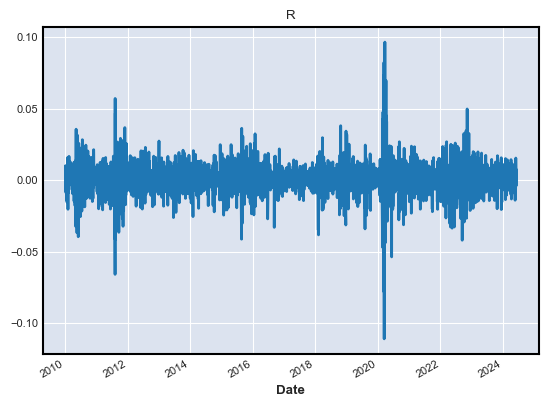

In [78]:
# calculate portfolio returns >>>
wY = Y.multiply(w.weights, axis=1)
wY['R'] = wY.sum(axis=1)
'''
display(wY)
'''
wY['R'].plot(title='R')

<Axes: title={'center': 'Rc'}, xlabel='Date'>

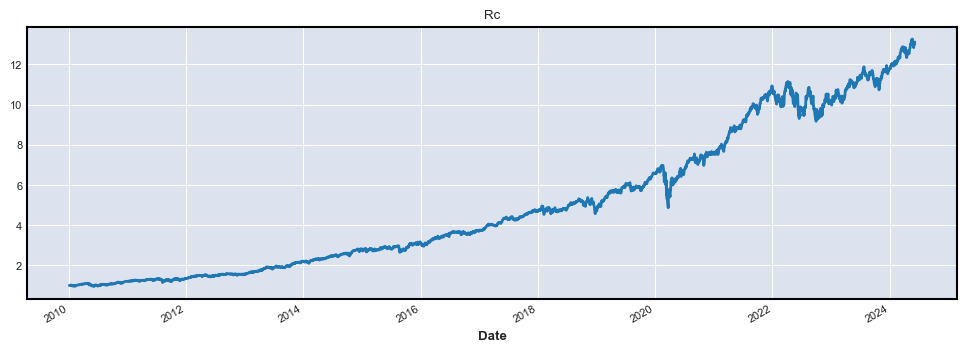

In [79]:
# cumulative returns >>
wY["Rc"] = (wY.R + 1).cumprod()

wY['Rc'].plot(title='Rc', figsize=(12,4))

C:\Users\mixas\anaconda3\Lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
C:\Users\mixas\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


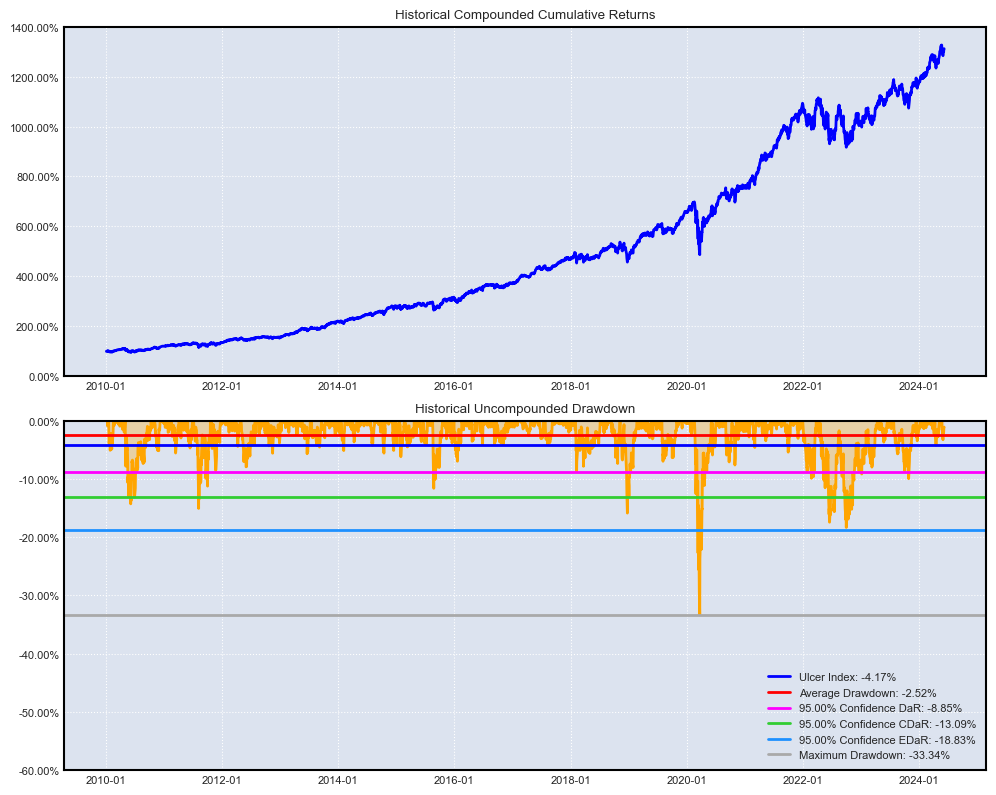

In [80]:
## evolution of portfolio prices and drawdown >>
# 'port.nav' is cumulative assets returns
nav=port.nav
ax = pf.plot_drawdown(nav=nav, w=w, alpha=0.05,
                       height=8, width=10)

In [81]:
tcb='SPY'
'''
dfb=si.get_data(tcb, start_date=start, end_date=end)
'''
dfb=si.get_data(tcb, start_date=start)

# returns >>
dfb['R'] = dfb['adjclose'].pct_change()
dfb = dfb.dropna()
# cumulative returns >>
dfb["Rc"] = (dfb.R + 1).cumprod()


Portfolio Rc 13.08 
Benchmark Rc 6.13


C:\Users\mixas\anaconda3\Lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


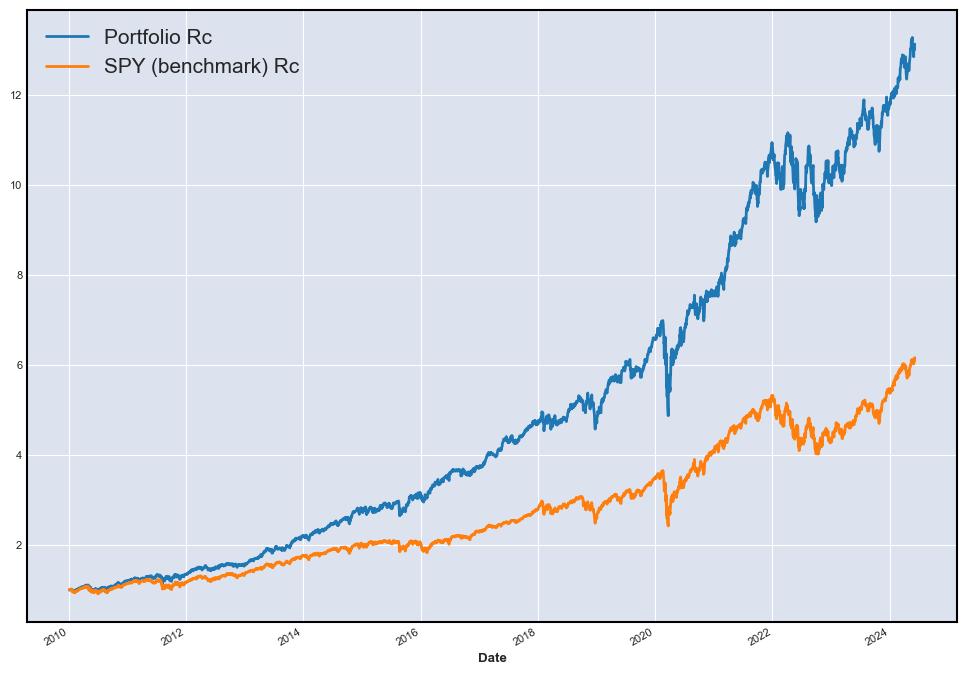

In [82]:
plt.figure(figsize=(12,9))
wY['Rc'].plot(label='Portfolio Rc')
plt.legend(loc='upper left', fontsize=15)
dfb['Rc'].plot(label=tcb+' (benchmark) Rc')
plt.legend(loc='upper left', fontsize=15)

print('\nPortfolio Rc',np.round(wY.iloc[-1]['Rc']/wY.iloc[1]['Rc'],2),
      '\nBenchmark Rc',np.round(dfb.iloc[-1]['Rc']/dfb.iloc[1]['Rc'],2))

<Axes: title={'center': 'SPY'}>

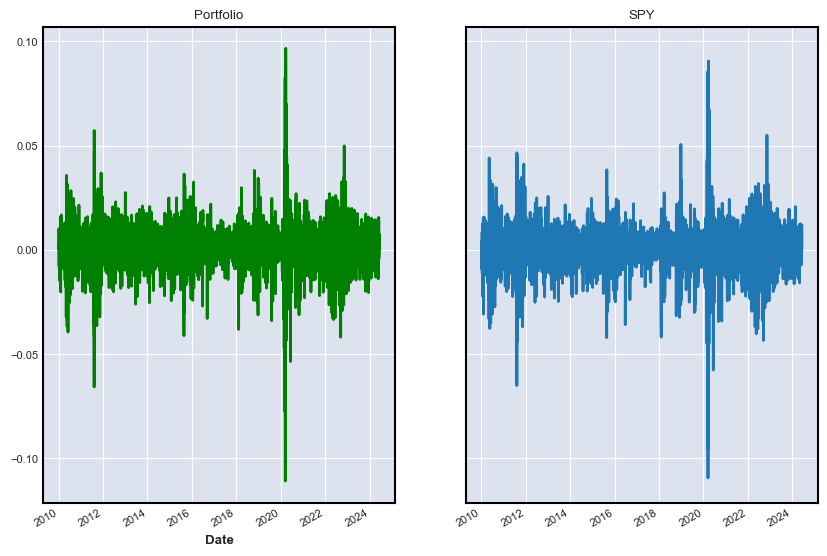

In [83]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,7))
wY['R'].plot(ax=ax1, color='g', lw=2., title='Portfolio')
dfb['R'].plot(ax=ax2, lw=2., title='SPY')

<Axes: xlabel='Date'>

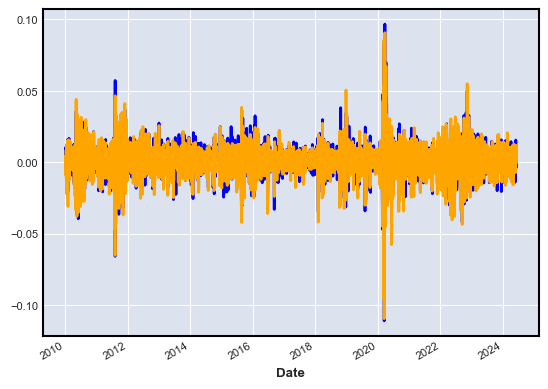

In [84]:
wY['R'].plot(color='b')
dfb['R'].plot(color='orange')

In [85]:
def sharpe_ratio(return_series):
  mean = return_series.mean()
  sigma = return_series.std()
  return (252**0.5) * (mean / sigma)


In [86]:
print(sharpe_ratio(wY['R']),
      '\n',sharpe_ratio(dfb['R']))

1.163238389587276 
 0.8206619059085059
